In [2]:
THEFOLDER = r"C:\Users\magst\OneDrive\Pictures\Desktop\HFT_FinalRun"

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Path to the shapefile
shapefile_path = f"{THEFOLDER}\shapefile\HazFuelTrt_PL_CO_WGSCRS.shp"
# Read the shapefile using GeoPandas
gdf = gpd.read_file(shapefile_path)

# Plot the shapefile
gdf.plot(figsize=(10, 10), color='lightblue', edgecolor='black')

# Add plot title and display the plot
plt.title("Hazardous Fuel Treatments - Colorado")
plt.show()
gdf

In [ ]:
import geopandas as gpd
import rasterio
from rasterio.features import rasterize
import os

# Base folder for input and output
#THEFOLDER = r"C:\Users\magst\OneDrive\Pictures\Desktop\HFT_Final"

# Path to the shapefile and reference raster
shapefile_path = os.path.join(THEFOLDER, "shapefile", "HazFuelTrt_PL_CO_WGSCRS_2001_2024.shp")
#reference_raster_path = os.path.join(THEFOLDER, "CHAPTER1_DataRerun", "WRC2020", "CO", "BP_CO.tif")
#reference_raster_path = r"C:\Users\magst\OneDrive\Pictures\Desktop\HFTCOMPELTEDATASET\CHAPTER1_DataRerun\WRC2020\CO\BP_CO.tif"
reference_raster_path = r"C:\Users\magst\OneDrive\Pictures\Desktop\HFTCOMPELTEDATASET\NatForest_CO_Name_WGS.tif"

# Define the list of activities to process, mapped to the output filenames
activities = {
    '1120': 'Activity_1120.tif',  # Yarding
    '1130': 'Activity_1130.tif',  # B of Piled Material
    '1153': 'Activity_1153.tif',  # Piling of Fuels
    '1160': 'Activity_1160.tif',  # Thinning for HFT
    '1111': 'Activity_1111.tif'   # Broadcast burning
}

# Load the shapefile once
gdf = gpd.read_file(shapefile_path)

# Open the reference raster to get extent, resolution, and CRS
with rasterio.open(reference_raster_path) as ref_src:
    transform = ref_src.transform
    ncols, nrows = ref_src.width, ref_src.height
    crs = ref_src.crs
    print(crs)
    out_meta = ref_src.meta.copy()

# Function to rasterize and save the output for each activity
def rasterize_activity(activity_code, output_filename):
    filtered_gdf = gdf[gdf['ACTIVITY_C'] == activity_code]
    if filtered_gdf.empty or filtered_gdf.geometry.is_empty.all():
        print(f"No valid geometries found for activity {activity_code}. Skipping...")
        return

    shapes = ((geom, value) for geom, value in zip(filtered_gdf.geometry, filtered_gdf['FY_PLANNED']))

    raster = rasterize(
        shapes,
        out_shape=(nrows, ncols),
        transform=transform,
        fill=0,
        dtype='uint16'
    )

    out_meta.update({
        'driver': 'GTiff',
        'height': nrows,
        'width': ncols,
        'transform': transform,
        'crs': crs,
        'dtype': 'uint16',
        'nodata': 65535
    })

    output_raster_path = os.path.join(THEFOLDER, "INTERMEDIATE", output_filename)
    with rasterio.open(output_raster_path, 'w', **out_meta) as out_raster:
        out_raster.write(raster, 1)

    print(f"Raster saved to: {output_raster_path}")

# Loop over each activity and rasterize it
for activity_code, output_filename in activities.items():
    rasterize_activity(activity_code, output_filename)


In [ ]:
import geopandas as gpd
import os

# Path to the shapefile
shapefile_path = os.path.join(THEFOLDER, "shapefile", "HazFuelTrt_PL_CO_WGSCRS.shp")

# Read the shapefile using GeoPandas
gdf = gpd.read_file(shapefile_path)

# Create a single polygon by combining all the polygons using unary_union
combined_polygon = gdf.unary_union

# Create a new GeoDataFrame to store the combined polygon
combined_gdf = gpd.GeoDataFrame(geometry=[combined_polygon], crs=gdf.crs)

# Output path for the combined shapefile
output_shapefile_path = os.path.join(THEFOLDER, "INTERMEDIATE", "HazFuelTrt_PL_CO_combined.shp")

# Export the combined polygon to a new shapefile
combined_gdf.to_file(output_shapefile_path)

print(f"Combined shapefile exported to: {output_shapefile_path}")


In [ ]:
import geopandas as gpd
import rasterio
from rasterio.features import rasterize
import os
import numpy as np

# Step 1: Load the shapefile
shapefile_path = os.path.join(THEFOLDER, "INTERMEDIATE", "HazFuelTrt_PL_CO_combined.shp")
gdf = gpd.read_file(shapefile_path)

# Step 2: Filter only valid geometries (if necessary, in this case it seems you're using all)
filtered_gdf = gdf

# Step 3: Ensure there are valid geometries after filtering
if filtered_gdf.empty or filtered_gdf.geometry.is_empty.all():
    raise ValueError("No valid geometries found in the filtered GeoDataFrame.")

# Step 4: Load the reference raster to match extent, resolution, and CRS
#reference_raster_path = os.path.join(THEFOLDER, "CHAPTER1_DataRerun", "WRC2020", "CO", "BP_CO.tif")
with rasterio.open(reference_raster_path) as ref_src:
    transform = ref_src.transform  # Get the transform of the reference raster
    ncols, nrows = ref_src.width, ref_src.height  # Get the width and height
    crs = ref_src.crs  # Get the CRS
    out_meta = ref_src.meta.copy()  # Copy the reference raster's metadata

# Step 5: Rasterize the filtered GeoDataFrame to match the reference raster's extent
shapes = ((geom, 1) for geom in filtered_gdf.geometry)  # 1 if the polygon is present
raster = rasterize(
    shapes,
    out_shape=(nrows, ncols),  # Match the shape of the reference raster
    transform=transform,  # Use the same transform as the reference raster
    fill=0,  # 0 where no polygon
    dtype='uint8'
)

# Step 6: Update metadata for the new raster, set nodata value to 255
out_meta.update({
    'driver': 'GTiff',
    'height': nrows,
    'width': ncols,
    'transform': transform,
    'crs': crs,
    'dtype': 'uint8',
    'nodata': 255  # Valid nodata value for uint8
})

# Step 7: Save the raster to a file
output_raster_path = os.path.join(THEFOLDER, "INTERMEDIATE", "COMBINED_30m_snapped.tif")
with rasterio.open(output_raster_path, 'w', **out_meta) as out_raster:
    out_raster.write(raster, 1)

print(f"Raster saved to: {output_raster_path}")


In [ ]:
import geopandas as gpd
import rasterio
import numpy as np
from shapely.geometry import Point
import os

# Step 1: Load the raster
raster_path = os.path.join(THEFOLDER, "INTERMEDIATE", "COMBINED_30m_snapped.tif")
with rasterio.open(raster_path) as src:
    raster_data = src.read(1)  # Read the first band
    transform = src.transform  # Get the transform
    crs = src.crs  # Get the CRS

# Step 2: Find the indices of pixels with value 1
rows, cols = np.where(raster_data == 1)

# Step 3: Convert these indices to geographic coordinates
points = [Point(transform * (col, row)) for row, col in zip(rows, cols)]

# Step 4: Create a GeoDataFrame with these points
gdf = gpd.GeoDataFrame(geometry=points, crs=crs)

# Step 5: Export the points to a shapefile
output_shp_path = os.path.join(THEFOLDER, "INTERMEDIATE", "COMBINED_30m_points.shp")
gdf.to_file(output_shp_path)

print(f"Points shapefile saved to: {output_shp_path}")


In [ ]:
import geopandas as gpd
import rasterio
import pandas as pd
from tqdm import tqdm  # Progress bar library
from rasterio.vrt import WarpedVRT
from rasterio import sample
import os

def extract_multi_values_to_points(points_shapefile, raster_files, reference_raster_path, output_csv=None):
    # Step 1: Load the point shapefile using GeoPandas
    points_gdf = gpd.read_file(points_shapefile)

    # Step 2: Load the reference raster to get the correct CRS
    with rasterio.open(reference_raster_path) as ref_src:
        target_crs = ref_src.crs

    # Step 3: Reproject point geometries if necessary
    if points_gdf.crs != target_crs:
        points_gdf = points_gdf.to_crs(target_crs)
    
    # Initialize an empty DataFrame to store the extracted values
    extracted_values = pd.DataFrame()

    # Add the point geometries to the DataFrame for reference
    extracted_values['geometry'] = points_gdf['geometry']
    
    # Convert point geometries to a list of coordinate tuples (x, y)
    point_coords = [(geom.x, geom.y) for geom in points_gdf.geometry]

    # Step 4: Loop through each raster file and extract the values at the point locations
    for raster_path in tqdm(raster_files, desc="Processing Rasters"):
        with rasterio.open(raster_path) as src:
            # Handle CRS reprojection if necessary
            if src.crs != target_crs:
                vrt_options = {
                    'crs': target_crs,
                    'resampling': rasterio.enums.Resampling.nearest
                }
                with WarpedVRT(src, **vrt_options) as vrt:
                    values = [val[0] for val in sample.sample_gen(vrt, point_coords)]
            else:
                # Extract the raster values at all point locations in one go
                values = [val[0] for val in sample.sample_gen(src, point_coords)]
        
        # Get the raster filename to use as a column name
        column_name = raster_path.split("\\")[-1].replace('.tif', '')
        extracted_values[column_name] = values
    
    # Step 5: Optionally save to CSV
    if output_csv:
        extracted_values.to_csv(output_csv, index=False)
        print(f"Extracted values saved to: {output_csv}")
    
    return extracted_values

# Example usage:
#points_shapefile = r"C:\Users\magst\OneDrive\Pictures\Desktop\HFTCOMPELTEDATASET\CHAPTER1_DataRerun\ColoradoHFT\COMBINED_30m_points_SUBSET.shp"
#points_shapefile = r"C:\Users\magst\OneDrive\Pictures\Desktop\HFTCOMPELTEDATASET\INTERMEDIATE\COMBINED_30m_points.shp"
points_shapefile = os.path.join(THEFOLDER, "INTERMEDIATE", "COMBINED_30m_points.shp")

#reference_raster_path = r"C:\Users\magst\OneDrive\Pictures\Desktop\HFTCOMPELTEDATASET\CHAPTER1_DataRerun\WRC2020\CO\BP_CO.tif"
#reference_raster_path = r"C:\Users\magst\OneDrive\Pictures\Desktop\HFTCOMPELTEDATASET\NatForest_CO_Name_WGS.tif"

raster_files = [
    f"{THEFOLDER}\INTERMEDIATE\Activity_1120.tif",
    f"{THEFOLDER}\INTERMEDIATE\Activity_1130.tif",
    f"{THEFOLDER}\INTERMEDIATE\Activity_1153.tif",
    f"{THEFOLDER}\INTERMEDIATE\Activity_1160.tif",
    f"{THEFOLDER}\INTERMEDIATE\Activity_1111.tif",

    r"C:\Users\magst\OneDrive\Pictures\Desktop\HFTCOMPELTEDATASET\CHAPTER1_DataRerun\WRC2020\CO\BP_CO.tif",
    r"C:\Users\magst\OneDrive\Pictures\Desktop\HFTCOMPELTEDATASET\CHAPTER1_DataRerun\WRC2020\CO\CFL_CO.tif",
    r"C:\Users\magst\OneDrive\Pictures\Desktop\HFTCOMPELTEDATASET\CHAPTER1_DataRerun\WRC2020\CO\CRPS_CO.tif",
    r"C:\Users\magst\OneDrive\Pictures\Desktop\HFTCOMPELTEDATASET\CHAPTER1_DataRerun\WRC2020\CO\Exposure_CO.tif",
    r"C:\Users\magst\OneDrive\Pictures\Desktop\HFTCOMPELTEDATASET\CHAPTER1_DataRerun\WRC2020\CO\FLEP4_CO.tif",
    r"C:\Users\magst\OneDrive\Pictures\Desktop\HFTCOMPELTEDATASET\CHAPTER1_DataRerun\WRC2020\CO\FLEP8_CO.tif",
    r"C:\Users\magst\OneDrive\Pictures\Desktop\HFTCOMPELTEDATASET\CHAPTER1_DataRerun\WRC2020\CO\RPS_CO.tif",
    r"C:\Users\magst\OneDrive\Pictures\Desktop\HFTCOMPELTEDATASET\CHAPTER1_DataRerun\WRC2020\CO\WHP_CO.tif",
    
    r"C:\Users\magst\OneDrive\Pictures\Desktop\HFTCOMPELTEDATASET\CHAPTER1_DataRerun\WRC2024\CO2\BP_CO2.tif",
    r"C:\Users\magst\OneDrive\Pictures\Desktop\HFTCOMPELTEDATASET\CHAPTER1_DataRerun\WRC2024\CO2\CFL_CO2.tif",
    r"C:\Users\magst\OneDrive\Pictures\Desktop\HFTCOMPELTEDATASET\CHAPTER1_DataRerun\WRC2024\CO2\CRPS_CO2.tif",
    r"C:\Users\magst\OneDrive\Pictures\Desktop\HFTCOMPELTEDATASET\CHAPTER1_DataRerun\WRC2024\CO2\Exposure_CO2.tif",
    r"C:\Users\magst\OneDrive\Pictures\Desktop\HFTCOMPELTEDATASET\CHAPTER1_DataRerun\WRC2024\CO2\FLEP4_CO2.tif",
    r"C:\Users\magst\OneDrive\Pictures\Desktop\HFTCOMPELTEDATASET\CHAPTER1_DataRerun\WRC2024\CO2\FLEP8_CO2.tif",
    r"C:\Users\magst\OneDrive\Pictures\Desktop\HFTCOMPELTEDATASET\CHAPTER1_DataRerun\WRC2024\CO2\RPS_CO2.tif",
    r"C:\Users\magst\OneDrive\Pictures\Desktop\HFTCOMPELTEDATASET\CHAPTER1_DataRerun\WRC2024\CO2\WHP_CO2.tif",

    r"C:\Users\magst\OneDrive\Pictures\Desktop\HFTCOMPELTEDATASET\NatForest_CO_Name_WGS.tif",
    r"C:\Users\magst\OneDrive\Pictures\Desktop\HFTCOMPELTEDATASET\CO_DEM.tif",
    r"C:\Users\magst\OneDrive\Pictures\Desktop\HFTCOMPELTEDATASET\CO_Slope.tif",
    r"C:\Users\magst\OneDrive\Pictures\Desktop\HFTCOMPELTEDATASET\CO_StructureEuc.tif",
    r"C:\Users\magst\OneDrive\Pictures\Desktop\HFTCOMPELTEDATASET\CO_RoadEuc.tif",
    r"C:\Users\magst\OneDrive\Pictures\Desktop\HFTCOMPELTEDATASET\CO_StreamEuc.tif",

    r"C:\Users\magst\OneDrive\Pictures\Desktop\HFTCOMPELTEDATASET\US_140_PLS\US_140_PLS\Tif\us_140pls.tif",
    r"C:\Users\magst\OneDrive\Pictures\Desktop\HFTCOMPELTEDATASET\US_140_PMS\US_140_PMS\Tif\us_140pms.tif",
    r"C:\Users\magst\OneDrive\Pictures\Desktop\HFTCOMPELTEDATASET\US_140_PRS\US_140_PRS\Tif\us_140prs.tif"
]

output_csv = os.path.join(THEFOLDER, "INTERMEDIATE", "extracted_valuesfull_HFT_NF.csv")

# Call the function
extracted_df = extract_multi_values_to_points(points_shapefile, raster_files, reference_raster_path, output_csv)
print("done")






# import geopandas as gpd
# import rasterio
# import pandas as pd
# from tqdm import tqdm  # Progress bar library
# from rasterio.vrt import WarpedVRT
# from rasterio import sample
# import os

# def extract_multi_values_to_points(points_shapefile, raster_files, reference_raster_path, output_csv=None, output_shapefile=None):
#     # Step 1: Load the point shapefile using GeoPandas
#     points_gdf = gpd.read_file(points_shapefile)

#     # Step 2: Load the reference raster to get the correct CRS
#     with rasterio.open(reference_raster_path) as ref_src:
#         target_crs = ref_src.crs

#     # Step 3: Reproject point geometries if necessary
#     if points_gdf.crs != target_crs:
#         points_gdf = points_gdf.to_crs(target_crs)
    
#     # Initialize an empty DataFrame to store the extracted values
#     extracted_values = pd.DataFrame()

#     # Add the point geometries to the DataFrame for reference
#     extracted_values['geometry'] = points_gdf['geometry']
    
#     # Convert point geometries to a list of coordinate tuples (x, y)
#     point_coords = [(geom.x, geom.y) for geom in points_gdf.geometry]

#     # Step 4: Loop through each raster file and extract the values at the point locations
#     for raster_path in tqdm(raster_files, desc="Processing Rasters"):
#         with rasterio.open(raster_path) as src:
#             # Handle CRS reprojection if necessary
#             if src.crs != target_crs:
#                 vrt_options = {
#                     'crs': target_crs,
#                     'resampling': rasterio.enums.Resampling.nearest
#                 }
#                 with WarpedVRT(src, **vrt_options) as vrt:
#                     values = [val[0] for val in sample.sample_gen(vrt, point_coords)]
#             else:
#                 # Extract the raster values at all point locations in one go
#                 values = [val[0] for val in sample.sample_gen(src, point_coords)]
        
#         # Get the raster filename to use as a column name
#         column_name = raster_path.split("\\")[-1].replace('.tif', '')
#         extracted_values[column_name] = values
    
#     # Step 5: Optionally save to CSV
#     if output_csv:
#         extracted_values.to_csv(output_csv, index=False)
#         print(f"Extracted values saved to: {output_csv}")
    
#     # Step 6: Optionally save to shapefile
#     if output_shapefile:
#         # Create a GeoDataFrame from the DataFrame with extracted values and the geometry
#         gdf_with_values = gpd.GeoDataFrame(extracted_values, geometry='geometry', crs=points_gdf.crs)
#         gdf_with_values.to_file(output_shapefile, driver='ESRI Shapefile')
#         print(f"Shapefile with extracted values saved to: {output_shapefile}")
    
#     return extracted_values

# # Example usage:
# points_shapefile = os.path.join(THEFOLDER, "INTERMEDIATE", "COMBINED_30m_points.shp")
# #reference_raster_path = r"C:\Users\magst\OneDrive\Pictures\Desktop\HFTCOMPELTEDATASET\CHAPTER1_DataRerun\WRC2020\CO\BP_CO.tif"

# raster_files = [
#     r"C:\Users\magst\OneDrive\Pictures\Desktop\HFTCOMPELTEDATASET\NatForest_CO_Name.tif"
# ]

# output_csv = os.path.join(THEFOLDER, "INTERMEDIATE", "extracted_valuesfull_HFT_NF5.csv")
# output_shapefile = os.path.join(THEFOLDER, "INTERMEDIATE", "extracted_points_HFT_NF5.shp")

# # Call the function
# extracted_df = extract_multi_values_to_points(points_shapefile, raster_files, reference_raster_path, output_csv, output_shapefile)
# print("done")



In [ ]:
import pandas as pd
import os

# # Read the CSV file into a pandas DataFrame
# #df = pd.read_csv(output_csv)

# # Read the CSV file into a pandas DataFrame
# output_csv = os.path.join(THEFOLDER, "INTERMEDIATE", "extracted_valuesfull_HFT_NF.csv")
# df = pd.read_csv(output_csv)
# print(df.columns)


In [3]:
import pandas as pd
import os

# Read the CSV file into a pandas DataFrame
#df = pd.read_csv(output_csv)

# Read the CSV file into a pandas DataFrame
output_csv = os.path.join(THEFOLDER, "INTERMEDIATE", "extracted_valuesfull_HFT_NF.csv")
df = pd.read_csv(output_csv)

# Filter the data based on the given conditions, removes NoData etc
df_filtered = df[
    (df['CO_RoadEuc'] >= 0) &
    (df['CO_Slope'] >= 0) &

    (df['BP_CO'] >= 0) &
    (df['CFL_CO'] >= 0) &
    (df['CRPS_CO'] >= 0) &
    (df['Exposure_CO'] >= 0) &
    (df['FLEP4_CO'] >= 0) &
    (df['FLEP8_CO'] >= 0) &
    (df['RPS_CO'] >= 0) &
    (df['WHP_CO'] >= 0) &
    (df['BP_CO2'] >= 0) &
    (df['CFL_CO2'] >= 0) &
    (df['CRPS_CO2'] >= 0) &
    (df['Exposure_CO2'] >= 0) &
    (df['FLEP4_CO2'] >= 0) &
    (df['FLEP8_CO2'] >= 0) &
    (df['RPS_CO2'] >= 0) &
    (df['WHP_CO2'] >= 0) &
    (df['NatForest_CO_Name_WGS'] >= 0) &
    (df['CO_DEM'] >= 0) &
    (df['CO_Slope'] >= 0) &
    (df['CO_StructureEuc'] >= 0) &
    (df['CO_RoadEuc'] >= 0) &
    (df['CO_StreamEuc'] >= 0) &
    (df['us_140pls'] >= 0) &

    (df['CO_DEM'] <= 3676) &
    (df['us_140pls'] <= 100) &
    (df['us_140pms'] <= 100) &
    (df['us_140prs'] <= 100) &
    (df['NatForest_CO_Name_WGS'] < 15)
]



# Identify the activity columns
activity_columns = ['Activity_1120', 'Activity_1130', 'Activity_1153', 'Activity_1160', 'Activity_1111']

# Create a new column 'Multiple_Treatments' indicating 1 if multiple treatments occurred, 0 otherwise
df_filtered['Multiple_Treatments'] = (df_filtered[activity_columns] != 0).sum(axis=1).gt(1).astype(int)

# Drop rows where 'Multiple_Treatments' is 1 and neither 'Activity_1111' nor 'Activity_1130' is non-zero
df_filtered = df_filtered[~((df_filtered['Multiple_Treatments'] == 1) & 
                           (df_filtered['Activity_1111'] == 0) & 
                           (df_filtered['Activity_1130'] == 0))]

# Create a new column 'Treatment_Label'
def treatment_label(row):
    if row['Multiple_Treatments'] == 1:
        return '1'
    else:
        for col in activity_columns:
            if row[col] != 0:
                return col.replace('Activity_', '')  # Return the year part of the activity column name
    return None

df_filtered['Treatment_Label'] = df_filtered.apply(treatment_label, axis=1)

# Get the lowest year for each row, ignoring zeros
lowest_year = df_filtered[activity_columns].replace(0, pd.NA).min(axis=1)

# Create a list of all the relevant variable pairs (current and future columns)
variables = ['BP_CO', 'CFL_CO', 'CRPS_CO', 'Exposure_CO', 'FLEP4_CO', 'FLEP8_CO', 'RPS_CO', 'WHP_CO']

# Use vectorized operations to create TRUE columns for each variable
for var in variables:
    current_col = var
    future_col = f"{var}2"
    df_filtered[f"{var}_TRUE"] = df_filtered[current_col].where(lowest_year < 2020, df_filtered[future_col])

# Print the modified DataFrame with the new columns
columns_to_print = ['geometry', 'Multiple_Treatments', 'Treatment_Label'] + [f'{var}_TRUE' for var in variables] + activity_columns
print(df_filtered[columns_to_print])
print(len(df_filtered))
df_filtered = df_filtered.dropna()

# Optionally, save the filtered data with the new columns to a new CSV file
#output_csv_path = os.path.join(THEFOLDER, "filtered_data_HFT.csv")
#df_filtered.to_csv(output_csv_path, index=False)
#print(f"Filtered data saved to: {output_csv_path}")

# Optionally sample 10% of the data for further processing
# df_filtered_sampled = df_filtered.sample(frac=0.1, random_state=42)  # random_state ensures reproducibility


C:\Users\magst\AppData\Local\Temp\ipykernel_4256\2821532385.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Multiple_Treatments'] = (df_filtered[activity_columns] != 0).sum(axis=1).gt(1).astype(int)


                                              geometry  Multiple_Treatments  \
0        POINT (-106.90552403051136 41.00217047015555)                    0   
1        POINT (-106.90517981209184 41.00217047015555)                    0   
2        POINT (-106.90483559367233 41.00217047015555)                    0   
3        POINT (-106.90449137525283 41.00217047015555)                    0   
4        POINT (-106.90414715683332 41.00217047015555)                    0   
...                                                ...                  ...   
1191602  POINT (-106.18163269428433 36.99490118523483)                    0   
1191603  POINT (-106.18128847586483 36.99490118523483)                    0   
1191604  POINT (-106.18094425744532 36.99490118523483)                    0   
1191605   POINT (-106.1806000390258 36.99490118523483)                    0   
1191606   POINT (-106.1802558206063 36.99490118523483)                    0   

        Treatment_Label  BP_CO_TRUE  CFL_CO_TRUE  C

In [4]:
df_filtered.NatForest_CO_Name_WGS.unique()

array([7, 4, 6, 8, 5, 2, 3], dtype=int64)

In [5]:
# Group by NatForest_CO_Name and count the occurrences of each Treatment_Label
treatment_counts = df_filtered.groupby(['NatForest_CO_Name_WGS', 'Treatment_Label']).size().unstack(fill_value=0)

# Display the result
print(treatment_counts)



Treatment_Label             1    1111   1120   1130   1153   1160
NatForest_CO_Name_WGS                                            
2                       37727   28565  42527   7129    114   1042
3                       47206  160702   4256  14964  30789    331
4                      113408   36932   3680   4794   6373    138
5                       18081   65877   1256  84658    710   2444
6                       18649  110727  23862   4323    284     30
7                        6361    2306    180  19579      1     69
8                       64140   76466      5  21285   3387  48074


In [6]:
# VIF
import statsmodels.api as sm

import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Select the variables for VIF calculation
variables = ['us_140prs', 'us_140pms', 'us_140pls', 'WHP_CO_TRUE', 'BP_CO_TRUE', 'FLEP4_CO_TRUE', 'FLEP8_CO_TRUE',
             'CRPS_CO_TRUE', 'CFL_CO_TRUE', 'CO_DEM', 'CO_Slope', 'CO_StreamEuc', 'CO_RoadEuc', 'CO_StructureEuc']

# Drop rows with missing values in the selected columns
df_clean = df_filtered[variables].dropna()

# Add a constant column to the dataframe for the intercept
X = sm.add_constant(df_clean)

# Calculate the VIF for each variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Print the VIF values
print(vif_data)


           Variable          VIF
0             const  2880.435965
1         us_140prs   198.104654
2         us_140pms    54.228526
3         us_140pls   199.064324
4       WHP_CO_TRUE     3.070363
5        BP_CO_TRUE     2.570600
6     FLEP4_CO_TRUE    10.713457
7     FLEP8_CO_TRUE     5.969711
8      CRPS_CO_TRUE    18.856146
9       CFL_CO_TRUE     3.800783
10           CO_DEM     2.238216
11         CO_Slope     1.214120
12     CO_StreamEuc     1.063702
13       CO_RoadEuc     1.282626
14  CO_StructureEuc     1.207342


In [7]:
import statistics 

# Replace original variable names with VIF-related ones and calculate summary statistics
print("WHP_CO_TRUE    - min", min(df_filtered['WHP_CO_TRUE']), "max", max(df_filtered['WHP_CO_TRUE']), 
      "Mean", statistics.mean(df_filtered['WHP_CO_TRUE']), "SD", statistics.stdev(df_filtered['WHP_CO_TRUE']))
print("BP_CO_TRUE     - min", min(df_filtered['BP_CO_TRUE']), "max", max(df_filtered['BP_CO_TRUE']), 
      "Mean", statistics.mean(df_filtered['BP_CO_TRUE']), "SD", statistics.stdev(df_filtered['BP_CO_TRUE']))
print("FLEP8_CO_TRUE  - min", min(df_filtered['FLEP8_CO_TRUE']), "max", max(df_filtered['FLEP8_CO_TRUE']), 
      "Mean", statistics.mean(df_filtered['FLEP8_CO_TRUE']), "SD", statistics.stdev(df_filtered['FLEP8_CO_TRUE']))
print("FLEP4_CO_TRUE  - min", min(df_filtered['FLEP4_CO_TRUE']), "max", max(df_filtered['FLEP4_CO_TRUE']), 
      "Mean", statistics.mean(df_filtered['FLEP4_CO_TRUE']), "SD", statistics.stdev(df_filtered['FLEP4_CO_TRUE']))
print("CRPS_CO_TRUE   - min", min(df_filtered['CRPS_CO_TRUE']), "max", max(df_filtered['CRPS_CO_TRUE']), 
      "Mean", statistics.mean(df_filtered['CRPS_CO_TRUE']), "SD", statistics.stdev(df_filtered['CRPS_CO_TRUE']))
print("CFL_CO_TRUE    - min", min(df_filtered['CFL_CO_TRUE']), "max", max(df_filtered['CFL_CO_TRUE']), 
      "Mean", statistics.mean(df_filtered['CFL_CO_TRUE']), "SD", statistics.stdev(df_filtered['CFL_CO_TRUE']))
print("CO_StreamEuc   - min", min(df_filtered['CO_StreamEuc']), "max", max(df_filtered['CO_StreamEuc']), 
      "Mean", statistics.mean(df_filtered['CO_StreamEuc']), "SD", statistics.stdev(df_filtered['CO_StreamEuc']))
print("CO_Slope       - min", min(df_filtered['CO_Slope']), "max", max(df_filtered['CO_Slope']), 
      "Mean", statistics.mean(df_filtered['CO_Slope']), "SD", statistics.stdev(df_filtered['CO_Slope']))
print("CO_RoadEuc     - min", min(df_filtered['CO_RoadEuc']), "max", max(df_filtered['CO_RoadEuc']), 
      "Mean", statistics.mean(df_filtered['CO_RoadEuc']), "SD", statistics.stdev(df_filtered['CO_RoadEuc']))
print("CO_DEM         - min", min(df_filtered['CO_DEM']), "max", max(df_filtered['CO_DEM']), 
      "Mean", statistics.mean(df_filtered['CO_DEM']), "SD", statistics.stdev(df_filtered['CO_DEM']))
print("CO_StructureEuc - min", min(df_filtered['CO_StructureEuc']), "max", max(df_filtered['CO_StructureEuc']), 
      "Mean", statistics.mean(df_filtered['CO_StructureEuc']), "SD", statistics.stdev(df_filtered['CO_StructureEuc']))
print("us_140prs      - min", min(df_filtered['us_140prs']), "max", max(df_filtered['us_140prs']), 
      "Mean", statistics.mean(df_filtered['us_140prs']), "SD", statistics.stdev(df_filtered['us_140prs']))
print("us_140pms      - min", min(df_filtered['us_140pms']), "max", max(df_filtered['us_140pms']), 
      "Mean", statistics.mean(df_filtered['us_140pms']), "SD", statistics.stdev(df_filtered['us_140pms']))
print("us_140pls      - min", min(df_filtered['us_140pls']), "max", max(df_filtered['us_140pls']), 
      "Mean", statistics.mean(df_filtered['us_140pls']), "SD", statistics.stdev(df_filtered['us_140pls']))


WHP_CO_TRUE    - min 0 max 16468 Mean 816.8854585510912 SD 1469.8740433271103
BP_CO_TRUE     - min 0.0 max 0.022441562 Mean 0.003639141057276143 SD 0.003987017491779256
FLEP8_CO_TRUE  - min 0.0 max 1.0 Mean 0.3023131233384795 SD 0.2813859688966562
FLEP4_CO_TRUE  - min 0.0 max 1.0 Mean 0.5136772541155314 SD 0.3490264983582181
CRPS_CO_TRUE   - min 0.0 max 99.86434 Mean 53.04430628908931 SD 21.30229285050123
CFL_CO_TRUE    - min 0.0 max 112.413 Mean 8.465146373088624 SD 9.203275557351658
CO_StreamEuc   - min 0.0 max 3411.5686 Mean 631.389590056043 SD 481.3248108400238
CO_Slope       - min 0 max 54 Mean 9.993253286463194 SD 7.36546455389648
CO_RoadEuc     - min 0.0 max 6723.4814 Mean 505.71550181033757 SD 764.1292930271647
CO_DEM         - min 1894 max 3676 Mean 2709.108578798327 SD 335.9916692796417
CO_StructureEuc - min 0.0 max 8399.196 Mean 1957.2483989854532 SD 1359.406842961625
us_140prs      - min 1 max 20 Mean 8.352725045377756 SD 5.50461900075259
us_140pms      - min 1 max 16 Mean 

In [8]:
unique_values = df_filtered['Treatment_Label'].unique()
unique_values

array(['1120', '1', '1153', '1130', '1111', '1160'], dtype=object)

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import roc_auc_score
import numpy as np
from keras import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC

# Assuming df_filtered is already loaded and contains the relevant columns and 'Treatment_Label'

# Define the features and the label
X = df_filtered[['BP_CO_TRUE', 'CFL_CO_TRUE', 'FLEP8_CO_TRUE', 'WHP_CO_TRUE', 'CO_DEM', 'CO_Slope', 
                 'CO_StructureEuc', 'CO_StreamEuc', 'CO_RoadEuc']]
y = df_filtered['Treatment_Label']

# One-hot encode the target
one_hot_encoder = OneHotEncoder(sparse_output=False)
y_encoded = one_hot_encoder.fit_transform(y.values.reshape(-1, 1))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

# MinMax scaling
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Neural network model
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)))
model.add(Dense(6, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy', AUC(name='auc')])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=10, batch_size=64, validation_data=(X_test_scaled, y_test))

# Evaluate the model
loss, accuracy, auc = model.evaluate(X_test_scaled, y_test)
print(f'Test Accuracy: {accuracy}')
print(f'Test AUC: {auc}')


Epoch 1/10


C:\Users\magst\anaconda3\envs\fire1\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12179/12179 ━━━━━━━━━━━━━━━━━━━━ 38s 3ms/step - accuracy: 0.5798 - auc: 0.8833 - loss: 1.0691 - val_accuracy: 0.6357 - val_auc: 0.9139 - val_loss: 0.9235
Epoch 2/10
12179/12179 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - accuracy: 0.6410 - auc: 0.9167 - loss: 0.9092 - val_accuracy: 0.6604 - val_auc: 0.9238 - val_loss: 0.8696
Epoch 3/10
12179/12179 ━━━━━━━━━━━━━━━━━━━━ 51s 4ms/step - accuracy: 0.6613 - auc: 0.9251 - loss: 0.8623 - val_accuracy: 0.6699 - val_auc: 0.9282 - val_loss: 0.8447
Epoch 4/10
12179/12179 ━━━━━━━━━━━━━━━━━━━━ 71s 3ms/step - accuracy: 0.6755 - auc: 0.9300 - loss: 0.8338 - val_accuracy: 0.6814 - val_auc: 0.9324 - val_loss: 0.8194
Epoch 5/10
12179/12179 ━━━━━━━━━━━━━━━━━━━━ 51s 4ms/step - accuracy: 0.6852 - auc: 0.9332 - loss: 0.8142 - val_accuracy: 0.6921 - val_auc: 0.9354 - val_loss: 0.8008
Epoch 6/10
12179/12179 ━━━━━━━━━━━━━━━━━━━━ 71s 3ms/step - accuracy: 0.6939 - auc: 0.9361 - loss: 0.7971 - val_accuracy: 0.6986 - val_auc: 0.9373 - val_loss: 0.7874
Epoch 7/10
12179/1217

In [10]:
# Print the number of training and testing samples
print(f'Number of training samples: {len(X_train)}')
print(f'Number of testing samples: {len(X_test)}')


Number of training samples: 779401
Number of testing samples: 334030


In [11]:
unieuq = df_filtered['NatForest_CO_Name_WGS'].unique()
unieuq

array([7, 4, 6, 8, 5, 2, 3], dtype=int64)

In [12]:
# import pandas as pd
# from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
# from sklearn.metrics import roc_auc_score
# from keras import Sequential
# from keras.layers import Dense
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.metrics import AUC
# from sklearn.metrics import accuracy_score, roc_auc_score

# # Assuming df_filtered is already loaded and contains the relevant columns and 'Treatment_Label'

# # Define the features and the label
# X = df_filtered[['BP_CO_TRUE', 'CFL_CO_TRUE', 'FLEP8_CO_TRUE', 'WHP_CO_TRUE', 'CO_DEM', 'CO_Slope', 
#                  'CO_StructureEuc', 'CO_StreamEuc', 'CO_RoadEuc']]
# y = df_filtered['Treatment_Label']

# # One-hot encode the target
# one_hot_encoder = OneHotEncoder(sparse_output=False)
# y_encoded = one_hot_encoder.fit_transform(y.values.reshape(-1, 1))

# # Get the list of unique national forests from the 'NatForest_CO_Name' column
# #forests = df_filtered['NatForest_CO_Name'].unique()
# forests = [ 7]
# # Initialize lists to hold results for each iteration
# accuracy_scores = []
# auc_scores = []

# # Loop over each forest to leave one out
# for forest in forests:
#     # Split the data: training data will be all other forests, test data will be the current left-out forest
#     train_indices = df_filtered['NatForest_CO_Name'] != forest
#     test_indices = df_filtered['NatForest_CO_Name'] == forest

#     X_train, X_test = X[train_indices], X[test_indices]
#     y_train, y_test = y_encoded[train_indices], y_encoded[test_indices]
    
#     # MinMax scaling
#     scaler = MinMaxScaler()
#     X_train_scaled = scaler.fit_transform(X_train)
#     X_test_scaled = scaler.transform(X_test)

#     # Neural network model
#     model = Sequential()
#     model.add(Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)))
#     model.add(Dense(6, activation='softmax'))
#     model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy', AUC(name='auc')])

#     # Train the model
#     model.fit(X_train_scaled, y_train, epochs=10, batch_size=64, verbose=0)  # Set verbose=0 to reduce console output

#     # Predict on the test set (left-out forest)
#     y_pred = model.predict(X_test_scaled)
    
#     # Calculate accuracy and AUC
#     y_test_labels = np.argmax(y_test, axis=1)  # True labels for the test set
#     y_pred_labels = np.argmax(y_pred, axis=1)  # Predicted labels

#     accuracy = accuracy_score(y_test_labels, y_pred_labels)
#     auc = roc_auc_score(y_test, y_pred, multi_class='ovo')

#     # Append the scores to the respective lists
#     accuracy_scores.append(accuracy)
#     auc_scores.append(auc)

#     print(f"Forest: {forest}, Accuracy: {accuracy}, AUC: {auc}")

# # After loop: Calculate the mean and standard deviation of accuracy and AUC scores
# mean_accuracy = np.mean(accuracy_scores)
# std_accuracy = np.std(accuracy_scores)
# mean_auc = np.mean(auc_scores)
# std_auc = np.std(auc_scores)

# print(f'Mean Accuracy: {mean_accuracy}, Std Accuracy: {std_accuracy}')
# print(f'Mean AUC: {mean_auc}, Std AUC: {std_auc}')


In [13]:
# # not quite
# import pandas as pd
# from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
# from sklearn.metrics import roc_auc_score, accuracy_score
# from keras import Sequential
# from keras.layers import Dense
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.metrics import AUC
# import numpy as np

# # Assuming df_filtered is already loaded and contains the relevant columns and 'Treatment_Label'

# # Define the features and the label
# X = df_filtered[['BP_CO_TRUE', 'CFL_CO_TRUE', 'FLEP8_CO_TRUE', 'WHP_CO_TRUE', 'CO_DEM', 'CO_Slope', 
#                  'CO_StructureEuc', 'CO_StreamEuc', 'CO_RoadEuc']]
# y = df_filtered['Treatment_Label']

# # One-hot encode the target
# one_hot_encoder = OneHotEncoder(sparse_output=False)
# y_encoded = one_hot_encoder.fit_transform(y.values.reshape(-1, 1))

# # Get the list of unique national forests from the 'NatForest_CO_Name' column
# #forests = df_filtered['NatForest_CO_Name'].unique()
# forests = [4, 6, 5, 8, 2, 3]
# print(forests)
# # Initialize lists to hold results for each iteration
# accuracy_scores = []
# auc_scores = []

# # Loop over each forest to leave one out
# for forest in forests:
#     print(forest)
#     # Split the data: training data will be all other forests, test data will be the current left-out forest
#     train_indices = df_filtered['NatForest_CO_Name'] != forest
#     test_indices = df_filtered['NatForest_CO_Name'] == forest

#     X_train, X_test = X[train_indices], X[test_indices]
#     y_train, y_test = y_encoded[train_indices], y_encoded[test_indices]
    
#     # MinMax scaling
#     scaler = MinMaxScaler()
#     X_train_scaled = scaler.fit_transform(X_train)
#     X_test_scaled = scaler.transform(X_test)

#     # Neural network model
#     model = Sequential()
#     model.add(Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)))
#     model.add(Dense(6, activation='softmax'))
#     model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy', AUC(name='auc')])

#     # Train the model
#     model.fit(X_train_scaled, y_train, epochs=10, batch_size=64, verbose=0)  # Set verbose=0 to reduce console output

#     # Predict on the test set (left-out forest)
#     y_pred = model.predict(X_test_scaled)
    
#     # Calculate accuracy
#     y_test_labels = np.argmax(y_test, axis=1)  # True labels for the test set
#     y_pred_labels = np.argmax(y_pred, axis=1)  # Predicted labels

#     accuracy = accuracy_score(y_test_labels, y_pred_labels)

#     # Check if the test set has at least two unique classes for AUC calculation
#     if len(np.unique(y_test_labels)) > 1:
#         auc = roc_auc_score(y_test, y_pred, multi_class='ovo')
#     else:
#         auc = None  # AUC is not defined for this forest

#     # Append the scores to the respective lists
#     accuracy_scores.append(accuracy)
#     auc_scores.append(auc)

#     print(f"Forest: {forest}, Accuracy: {accuracy}, AUC: {auc if auc is not None else 'N/A'}")

# # After loop: Calculate the mean and standard deviation of accuracy and AUC scores, excluding None values in AUC
# mean_accuracy = np.mean(accuracy_scores)
# std_accuracy = np.std(accuracy_scores)
# mean_auc = np.mean([auc for auc in auc_scores if auc is not None])
# std_auc = np.std([auc for auc in auc_scores if auc is not None])

# print(f'Mean Accuracy: {mean_accuracy}, Std Accuracy: {std_accuracy}')
# print(f'Mean AUC: {mean_auc}, Std AUC: {std_auc}')


In [14]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import roc_auc_score, accuracy_score
from keras import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
import numpy as np

# Assuming df_filtered is already loaded and contains the relevant columns and 'Treatment_Label'

# Define the features and the label
X2 = df_filtered[['BP_CO_TRUE', 'CFL_CO_TRUE', 'FLEP8_CO_TRUE', 'WHP_CO_TRUE', 'CO_DEM', 'CO_Slope', 
                 'CO_StructureEuc', 'CO_StreamEuc', 'CO_RoadEuc']]
y2 = df_filtered['Treatment_Label']

# One-hot encode the target
one_hot_encoder = OneHotEncoder(sparse_output=False)
y_encoded = one_hot_encoder.fit_transform(y2.values.reshape(-1, 1))

# Get the list of unique national forests from the 'NatForest_CO_Name' column
#forests = [4, 6, 5, 8, 2, 3]
forests = [2, 3, 4, 5, 6, 7, 8]

print(forests)

# Get class names for readability
class_labels = one_hot_encoder.categories_[0]

# Loop over each forest to leave one out
for forest in forests:
    print(f"\nProcessing Forest: {forest}")
    # Split the data: training data will be all other forests, test data will be the current left-out forest
    train_indices = df_filtered['NatForest_CO_Name_WGS'] != forest
    test_indices = df_filtered['NatForest_CO_Name_WGS'] == forest

    X_train2, X_test2 = X2[train_indices], X2[test_indices]
    y_train2, y_test2 = y_encoded[train_indices], y_encoded[test_indices]
    
    # MinMax scaling
    scaler2 = MinMaxScaler()
    X_train_scaled2 = scaler2.fit_transform(X_train2)
    X_test_scaled2 = scaler2.transform(X_test2)

    # Neural network model
    model2 = Sequential()
    model2.add(Dense(64, activation='relu', input_shape=(X_train_scaled2.shape[1],)))
    model2.add(Dense(6, activation='softmax'))
    model2.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy', AUC(name='auc')])

    # Train the model
    model2.fit(X_train_scaled2, y_train2, epochs=10, batch_size=64, verbose=0)  # Set verbose=0 to reduce console output

    # Predict on the test set (left-out forest)
    y_pred2 = model2.predict(X_test_scaled2)

    # Calculate per-class AUC (One-vs-Rest) and print it for each class
    print(f"AUC for each class vs the rest for Forest {forest}:")
    for i, label in enumerate(class_labels):
        # AUC for the current class vs the rest
        if len(np.unique(y_test[:, i])) > 1:  # Ensure that there is more than one class in the test set
            auc = roc_auc_score(y_test2[:, i], y_pred2[:, i])
            print(f"  Class: {label}, AUC: {auc}")
        else:
            print(f"  Class: {label}, AUC: Not defined (only one class present)")

print("Processing completed for all forests.")


[2, 3, 4, 5, 6, 7, 8]

Processing Forest: 2


C:\Users\magst\anaconda3\envs\fire1\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3660/3660 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
AUC for each class vs the rest for Forest 2:
  Class: 1, AUC: 0.4816159810850854
  Class: 1111, AUC: 0.9275283546789986
  Class: 1120, AUC: 0.48192036790006193
  Class: 1130, AUC: 0.690617714255631
  Class: 1153, AUC: 0.7645613735167048
  Class: 1160, AUC: 0.8283389741951082

Processing Forest: 3


C:\Users\magst\anaconda3\envs\fire1\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8071/8071 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step
AUC for each class vs the rest for Forest 3:
  Class: 1, AUC: 0.6582042116908268
  Class: 1111, AUC: 0.6894003416337577
  Class: 1120, AUC: 0.9091446596535987
  Class: 1130, AUC: 0.662976477559065
  Class: 1153, AUC: 0.46367671097497326
  Class: 1160, AUC: 0.5247904994190794

Processing Forest: 4


C:\Users\magst\anaconda3\envs\fire1\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5167/5167 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step
AUC for each class vs the rest for Forest 4:
  Class: 1, AUC: 0.694259370189649
  Class: 1111, AUC: 0.8215932415554958
  Class: 1120, AUC: 0.7952701395772
  Class: 1130, AUC: 0.6928502954058599
  Class: 1153, AUC: 0.5229297994757549
  Class: 1160, AUC: 0.34958004994427483

Processing Forest: 5


C:\Users\magst\anaconda3\envs\fire1\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5408/5408 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
AUC for each class vs the rest for Forest 5:
  Class: 1, AUC: 0.5472197105417188
  Class: 1111, AUC: 0.9451952768734065
  Class: 1120, AUC: 0.8027634438586037
  Class: 1130, AUC: 0.7159216309922052
  Class: 1153, AUC: 0.14493333816123605
  Class: 1160, AUC: 0.8707601756044546

Processing Forest: 6


C:\Users\magst\anaconda3\envs\fire1\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4934/4934 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step
AUC for each class vs the rest for Forest 6:
  Class: 1, AUC: 0.719365918964488
  Class: 1111, AUC: 0.8070100379197191
  Class: 1120, AUC: 0.84499177358802
  Class: 1130, AUC: 0.7366818251477163
  Class: 1153, AUC: 0.6137913073430142
  Class: 1160, AUC: 0.459103128596619

Processing Forest: 7


C:\Users\magst\anaconda3\envs\fire1\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


891/891 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
AUC for each class vs the rest for Forest 7:
  Class: 1, AUC: 0.6645387682102654
  Class: 1111, AUC: 0.9225663450129433
  Class: 1120, AUC: 0.40801627662413087
  Class: 1130, AUC: 0.5916447866595995
  Class: 1153, AUC: 0.376802947885594
  Class: 1160, AUC: 0.9416644616798788

Processing Forest: 8


C:\Users\magst\anaconda3\envs\fire1\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6668/6668 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
AUC for each class vs the rest for Forest 8:
  Class: 1, AUC: 0.6020828516980037
  Class: 1111, AUC: 0.6826721599870471
  Class: 1120, AUC: 0.0853987776069594
  Class: 1130, AUC: 0.3563745893563346
  Class: 1153, AUC: 0.4291658885457494
  Class: 1160, AUC: 0.3251492830324716
Processing completed for all forests.


In [15]:
from joblib import dump, load
import os
from keras.models import load_model


# Create directory for saving the model, scaler, and encoder if it doesn't exist
save_dir = os.path.join(THEFOLDER, "MODELS")
os.makedirs(save_dir, exist_ok=True)

# Save the scaler using joblib
scaler_path = os.path.join(save_dir, 'scaler.pkl')
dump(scaler, scaler_path)

# Save the one-hot encoder using joblib
encoder_path = os.path.join(save_dir, 'encoder.pkl')
dump(one_hot_encoder, encoder_path)

# Save the model using Keras's save method
model_path = os.path.join(save_dir, 'model.h5')
model.save(model_path)

print(f'Model saved to {model_path}')
print(f'Scaler saved to {scaler_path}')
print(f'Encoder saved to {encoder_path}')


Model saved to C:\Users\magst\OneDrive\Pictures\Desktop\HFT_FinalRun\MODELS\model.h5
Scaler saved to C:\Users\magst\OneDrive\Pictures\Desktop\HFT_FinalRun\MODELS\scaler.pkl
Encoder saved to C:\Users\magst\OneDrive\Pictures\Desktop\HFT_FinalRun\MODELS\encoder.pkl


In [16]:
from keras.models import load_model
from joblib import load
import os

# Load the scaler
scaler_path = os.path.join(THEFOLDER, 'MODELS', 'scaler.pkl')
scaler = load(scaler_path)

# Load the one-hot encoder
encoder_path = os.path.join(THEFOLDER, 'MODELS', 'encoder.pkl')
one_hot_encoder = load(encoder_path)

# Load the model
model_path = os.path.join(THEFOLDER, 'MODELS', 'model.h5')
model = load_model(model_path)

print("Model, scaler, and encoder reloaded successfully.")


Model, scaler, and encoder reloaded successfully.


In [17]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

# One-hot encode the target
one_hot_encoder = OneHotEncoder(sparse_output=False)  # Use sparse_output instead of sparse
y_encoded = one_hot_encoder.fit_transform(y.values.reshape(-1, 1))

# Get the class names
class_names = one_hot_encoder.categories_[0]
print(f"Class Names (Treatment Codes): {class_names}")

Class Names (Treatment Codes): ['1' '1111' '1120' '1130' '1153' '1160']


In [18]:
df_filtered

,geometry,Activity_1120,Activity_1130,Activity_1153,Activity_1160,Activity_1111,BP_CO,CFL_CO,CRPS_CO,Exposure_CO,...,Multiple_Treatments,Treatment_Label,BP_CO_TRUE,CFL_CO_TRUE,CRPS_CO_TRUE,Exposure_CO_TRUE,FLEP4_CO_TRUE,FLEP8_CO_TRUE,RPS_CO_TRUE,WHP_CO_TRUE
1,POINT (-106.90517981209184 41.00217047015555),2016,0,0,0,0,0.002083,10.253365,74.239426,1.0,...,0,1120,0.002083,10.253365,74.239426,1.0,0.857656,0.515564,0.154628,725
2,POINT (-106.90483559367233 41.00217047015555),2016,0,0,0,0,0.002087,10.398497,74.685430,1.0,...,0,1120,0.002087,10.398497,74.685430,1.0,0.862753,0.523742,0.155889,739
3,POINT (-106.90449137525283 41.00217047015555),2016,0,0,0,0,0.002091,10.490509,74.770030,1.0,...,0,1120,0.002091,10.490509,74.770030,1.0,0.861004,0.527969,0.156375,745
4,POINT (-106.90414715683332 41.00217047015555),2016,0,0,0,0,0.002095,10.524098,74.466880,1.0,...,0,1120,0.002095,10.524098,74.466880,1.0,0.851735,0.528254,0.156028,742
5,POINT (-106.9038029384138 41.00217047015555),2016,0,0,0,0,0.002099,10.493716,73.752450,1.0,...,0,1120,0.002099,10.493716,73.752450,1.0,0.834345,0.524643,0.154793,730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1191602,POINT (-106.18163269428433 36.99490118523483),0,0,0,0,2019,0.000617,6.311295,63.147110,1.0,...,0,1111,0.000617,6.311295,63.147110,1.0,0.828192,0.324948,0.038938,90
1191603,POINT (-106.18128847586483 36.99490118523483),0,0,0,0,2019,0.000612,6.219652,62.134796,1.0,...,0,1111,0.000612,6.219652,62.134796,1.0,0.803147,0.319003,0.038007,87
1191604,POINT (-106.18094425744532 36.99490118523483),0,0,0,0,2019,0.000607,6.154455,61.250088,1.0,...,0,1111,0.000607,6.154455,61.250088,1.0,0.779181,0.315290,0.037170,86
1191605,POINT (-106.1806000390258 36.99490118523483),0,0,0,0,2019,0.000597,6.130093,59.890705,1.0,...,0,1111,0.000597,6.130093,59.890705,1.0,0.733132,0.316704,0.035784,86


In [19]:
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
# from sklearn.metrics import roc_auc_score
# import numpy as np
# from keras import Sequential
# from keras.layers import Dense
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.metrics import AUC

# # Assuming df_filtered is already loaded and contains the relevant columns and 'Treatment_Label'

# # Define the features and the label
# X = df_filtered[['BP_CO_TRUE', 'CFL_CO_TRUE', 'FLEP8_CO_TRUE', 'WHP_CO_TRUE', 'CO_DEM', 'CO_Slope', 
#                  'CO_StructureEuc', 'CO_StreamEuc', 'CO_RoadEuc']]
# y = df_filtered['Treatment_Label']

# # One-hot encode the target
# one_hot_encoder = OneHotEncoder(sparse_output=False)
# y_encoded = one_hot_encoder.fit_transform(y.values.reshape(-1, 1))

# # Train-test split
# X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

# # MinMax scaling
# scaler = MinMaxScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

10439/10439 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step
BP_CO_TRUE: 0.1315 ± 0.0003
CFL_CO_TRUE: 0.1710 ± 0.0007
FLEP8_CO_TRUE: 0.1314 ± 0.0004
WHP_CO_TRUE: 0.1437 ± 0.0005
CO_DEM: 0.2216 ± 0.0007
CO_Slope: 0.0384 ± 0.0004
CO_StructureEuc: 0.0826 ± 0.0004
CO_StreamEuc: 0.0345 ± 0.0004
CO_RoadEuc: 0.0467 ± 0.0004


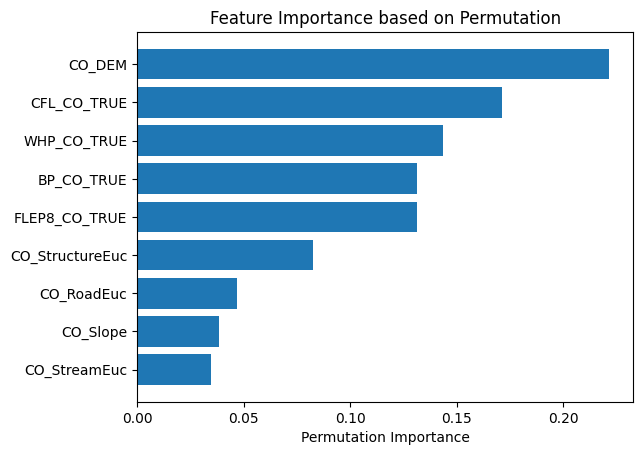

In [20]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.inspection import permutation_importance
import numpy as np
import matplotlib.pyplot as plt

# Create a wrapper class for your Keras model
class KerasClassifierWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, model):
        self.model = model
    
    def fit(self, X, y):
        # No need to fit again, as we already trained the Keras model
        pass
    
    def predict(self, X):
        return np.argmax(self.model.predict(X), axis=1)

# Initialize the wrapper
model_wrapper = KerasClassifierWrapper(model)

# Using sklearn's permutation_importance with the wrapper
perm_importance = permutation_importance(
    estimator=model_wrapper, 
    X=X_test_scaled, 
    y=np.argmax(y_test, axis=1),  # Converting one-hot encoded labels to single class labels
    n_repeats=10,  # Number of shuffles
    random_state=42,
    n_jobs=-1  # Use all available CPUs
)

# Print the feature importance scores
for i, feature in enumerate(X.columns):
    print(f"{feature}: {perm_importance.importances_mean[i]:.4f} ± {perm_importance.importances_std[i]:.4f}")

# Sort and display feature importance
sorted_idx = perm_importance.importances_mean.argsort()

plt.barh(X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("Feature Importance based on Permutation")
plt.show()


In [21]:
# from sklearn.metrics import roc_auc_score
# from sklearn.utils import resample
# import numpy as np

# # Step 1: Predict probabilities for the test set
# y_pred_prob = model.predict(X_test_scaled)

# # Step 2: Compute AUC for each class
# n_classes = y_test.shape[1]  # Number of classes (since y_test is one-hot encoded)
# auc_scores = {}
# for i in range(n_classes):
#     auc = roc_auc_score(y_test[:, i], y_pred_prob[:, i])
#     auc_scores[f'Class {i}'] = auc
#     print(f'AUC for Class {i}: {auc:.4f}')

# # Step 3: Bootstrapping to calculate standard error of AUC
# n_bootstraps = 10
# rng = np.random.RandomState(42)
# bootstrap_auc_scores = {f'Class {i}': [] for i in range(n_classes)}

# # Perform bootstrapping
# for i in range(n_classes):
#     for _ in range(n_bootstraps):
#         # Resample the data with replacement
#         indices = resample(np.arange(len(X_test_scaled)), random_state=rng)
#         y_test_resampled = y_test[indices, i]
#         y_pred_resampled = y_pred_prob[indices, i]
        
#         # Compute AUC for the resampled data
#         if len(np.unique(y_test_resampled)) > 1:  # Ensure at least 2 classes present
#             auc = roc_auc_score(y_test_resampled, y_pred_resampled)
#             bootstrap_auc_scores[f'Class {i}'].append(auc)

# # Step 4: Calculate the standard error for each class based on the bootstrapped AUC scores
# bootstrap_se = {}
# for i in range(n_classes):
#     bootstrap_se[f'Class {i}'] = np.std(bootstrap_auc_scores[f'Class {i}'])
#     print(f"Standard Error for Class {i}: {bootstrap_se[f'Class {i}']:.4f}")



from sklearn.metrics import roc_auc_score
from sklearn.utils import resample
import numpy as np

# Step 1: Predict probabilities for the test set
y_pred_prob = model.predict(X_test_scaled)

# Step 2: Get class names from the OneHotEncoder
class_names = one_hot_encoder.categories_[0]
print(f"Class Names (Treatment Codes): {class_names}")

# Step 3: Compute AUC for each class using class names
n_classes = y_test.shape[1]  # Number of classes (since y_test is one-hot encoded)
auc_scores = {}
for i in range(n_classes):
    auc = roc_auc_score(y_test[:, i], y_pred_prob[:, i])
    class_name = class_names[i]
    auc_scores[f'Class {class_name}'] = auc
    print(f'AUC for Class {class_name}: {auc:.4f}')

# Step 4: Bootstrapping to calculate standard error of AUC
n_bootstraps = 10
rng = np.random.RandomState(42)
bootstrap_auc_scores = {f'Class {class_names[i]}': [] for i in range(n_classes)}

# Perform bootstrapping
for i in range(n_classes):
    for _ in range(n_bootstraps):
        # Resample the data with replacement
        indices = resample(np.arange(len(X_test_scaled)), random_state=rng)
        y_test_resampled = y_test[indices, i]
        y_pred_resampled = y_pred_prob[indices, i]
        
        # Compute AUC for the resampled data
        if len(np.unique(y_test_resampled)) > 1:  # Ensure at least 2 classes present
            auc = roc_auc_score(y_test_resampled, y_pred_resampled)
            bootstrap_auc_scores[f'Class {class_names[i]}'].append(auc)

# Step 5: Calculate the standard error for each class based on the bootstrapped AUC scores
bootstrap_se = {}
for i in range(n_classes):
    class_name = class_names[i]
    bootstrap_se[f'Class {class_name}'] = np.std(bootstrap_auc_scores[f'Class {class_name}'])
    print(f"Standard Error for Class {class_name}: {bootstrap_se[f'Class {class_name}']:.4f}")




10439/10439 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step
Class Names (Treatment Codes): ['1' '1111' '1120' '1130' '1153' '1160']
AUC for Class 1: 0.8663
AUC for Class 1111: 0.9453
AUC for Class 1120: 0.9216
AUC for Class 1130: 0.9096
AUC for Class 1153: 0.9216
AUC for Class 1160: 0.9467
Standard Error for Class 1: 0.0008
Standard Error for Class 1111: 0.0003
Standard Error for Class 1120: 0.0007
Standard Error for Class 1130: 0.0006
Standard Error for Class 1153: 0.0010
Standard Error for Class 1160: 0.0011


In [22]:
from sklearn.metrics import roc_auc_score
import numpy as np



from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

# One-hot encode the target
one_hot_encoder = OneHotEncoder(sparse_output=False)  # Use sparse_output instead of sparse
y_encoded = one_hot_encoder.fit_transform(y.values.reshape(-1, 1))

# Get the class names
class_names = one_hot_encoder.categories_[0]
print(f"Class Names (Treatment Codes): {class_names}")



# Step 1: Predict probabilities for the test set
y_pred_prob = model.predict(X_test_scaled)

# Step 2: Compute AUC for each class
n_classes = y_test.shape[1]  # Number of classes (since y_test is one-hot encoded)
auc_scores = []
for i in range(n_classes):
    auc = roc_auc_score(y_test[:, i], y_pred_prob[:, i])
    auc_scores.append(auc)
    print(f'AUC for Class {i}: {auc:.4f}')

# Step 3: Compute macro-averaged AUC
macro_auc = np.mean(auc_scores)
print(f'Macro-Averaged AUC: {macro_auc:.4f}')

# Step 4: Calculate standard deviation of AUC scores
std_auc = np.std(auc_scores)
print(f'Standard Deviation of AUC: {std_auc:.4f}')


Class Names (Treatment Codes): ['1' '1111' '1120' '1130' '1153' '1160']
10439/10439 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step
AUC for Class 0: 0.8663
AUC for Class 1: 0.9453
AUC for Class 2: 0.9216
AUC for Class 3: 0.9096
AUC for Class 4: 0.9216
AUC for Class 5: 0.9467
Macro-Averaged AUC: 0.9185
Standard Deviation of AUC: 0.0269


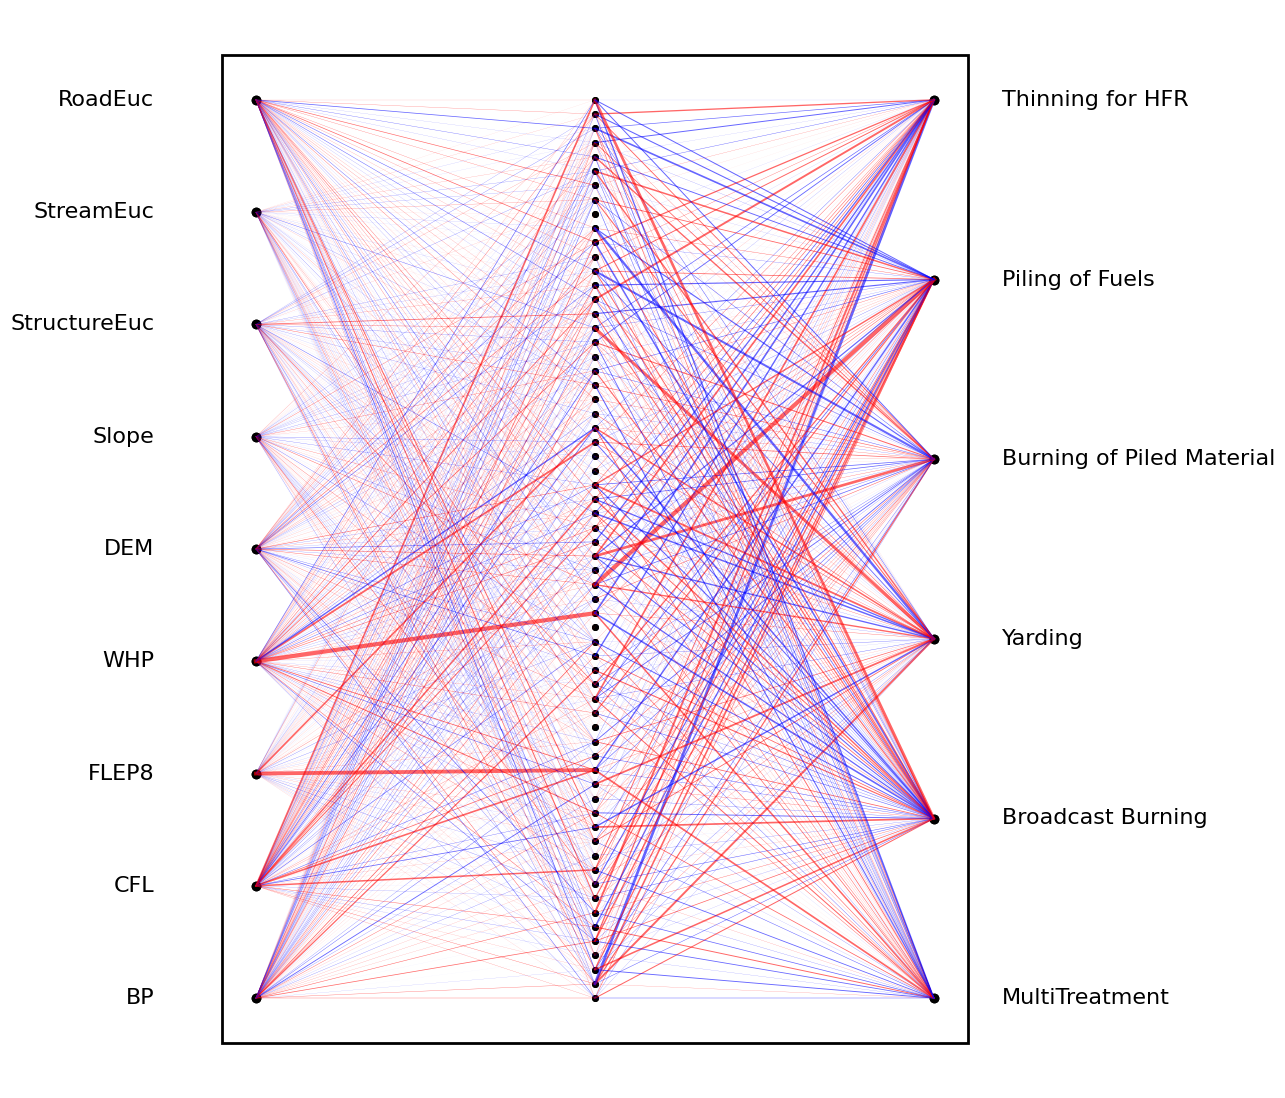

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Extract the weights from the model layers
weights_hidden = model.layers[0].get_weights()[0]  # Weights between input and hidden layer (shape: [num_features, 64])
weights_output = model.layers[1].get_weights()[0]  # Weights between hidden layer and output layer (shape: [64, 6])

# Normalize weights for line thickness (for better visualization)
weights_hidden_norm = np.abs(weights_hidden) / np.max(np.abs(weights_hidden))
weights_output_norm = np.abs(weights_output) / np.max(np.abs(weights_output))

# Define the labels
input_labels = ['BP', 'CFL', 'FLEP8', 'WHP', 'DEM', 'Slope', 
                'StructureEuc', 'StreamEuc', 'RoadEuc']  # Input features
output_labels = ['MultiTreatment', 'Broadcast Burning', 'Yarding', 'Burning of Piled Material', 'Piling of Fuels', 'Thinning for HFR']  # Output classes

# Create a figure with more height
fig, ax = plt.subplots(figsize=(14, 14))  # Make it square

# Define node positions with consistent vertical spacing
input_layer_pos = np.linspace(0, 1, weights_hidden.shape[0])  # Input layer positions, evenly spaced
hidden_layer_pos = np.linspace(0, 1, 64)  # Hidden layer positions, evenly spaced
output_layer_pos = np.linspace(0, 1, 6)  # Output layer positions, evenly spaced

# Plot the input nodes (features)
for i, pos in enumerate(input_layer_pos):
    ax.plot([0, 0], [pos, pos], 'ko', markersize=6)  # Adjusted node size
    ax.text(-0.15, pos, input_labels[i], ha='right', va='center', fontsize=16)  # Add labels on the left

# Plot the hidden nodes (neurons in the middle layer)
for i, pos in enumerate(hidden_layer_pos):
    ax.plot([0.5, 0.5], [pos, pos], 'ko', markersize=4)  # Adjusted node size

# Plot the output nodes (6 classes)
for i, pos in enumerate(output_layer_pos):
    ax.plot([1, 1], [pos, pos], 'ko', markersize=6)  # Adjusted node size
    ax.text(1.1, pos, output_labels[i], ha='left', va='center', fontsize=16)  # Add labels on the right

# Plot the weights between input and hidden layer
for i, input_pos in enumerate(input_layer_pos):
    for j, hidden_pos in enumerate(hidden_layer_pos):
        weight = weights_hidden[i, j]
        color = 'blue' if weight > 0 else 'red'
        ax.plot([0, 0.5], [input_pos, hidden_pos], color=color, lw=weights_hidden_norm[i, j] * 3, alpha=0.6)  # Adjusted thickness scaling

# Plot the weights between hidden and output layer
for i, hidden_pos in enumerate(hidden_layer_pos):
    for j, output_pos in enumerate(output_layer_pos):
        weight = weights_output[i, j]
        color = 'blue' if weight > 0 else 'red'
        ax.plot([0.5, 1], [hidden_pos, output_pos], color=color, lw=weights_output_norm[i, j] * 3, alpha=0.6)  # Adjusted thickness scaling

# Set limits and labels
ax.set_xlim([-0.3, 1.3])  # Adjust horizontal limits for more spacing
ax.set_ylim([-0.1, 1.1])  # Adjust vertical limits to make it more squared
ax.axis('off')

# Add a box around the neural network (excluding labels)
box = plt.Rectangle((-0.05, -0.05), 1.1, 1.1, fill=False, edgecolor='black', lw=2)
ax.add_patch(box)

plt.savefig(r'C:\Users\magst\OneDrive\Pictures\Desktop\HFT_Final\NNWeightsFigure.png', format='png', dpi=300, bbox_inches='tight')

plt.show()


In [24]:
# Extract the weights from the model layers
weights_hidden = model.layers[0].get_weights()[0]  # Weights between input and hidden layer (shape: [num_features, 64])
weights_output = model.layers[1].get_weights()[0]  # Weights between hidden layer and output layer (shape: [64, 6])

# Get min and max weights for both layers
min_hidden_weight = np.min(weights_hidden)
max_hidden_weight = np.max(weights_hidden)
min_output_weight = np.min(weights_output)
max_output_weight = np.max(weights_output)

# Print the min and max weights
print(f"Hidden layer weights - Min: {min_hidden_weight}, Max: {max_hidden_weight}")
print(f"Output layer weights - Min: {min_output_weight}, Max: {max_output_weight}")


Hidden layer weights - Min: -15.202292442321777, Max: 4.959985733032227
Output layer weights - Min: -11.54533863067627, Max: 7.337747573852539


In [25]:
# Extract the weights from the hidden layer
weights_hidden = model.layers[0].get_weights()[0]  # Weights between input and hidden layer (shape: [num_features, 64])

# Define the labels (input features)
input_labels = ['BP', 'CFL', 'FLEP8', 'WHP', 'DEM', 'Slope', 
                'StructureEuc', 'StreamEuc', 'RoadEuc']  # Input features

# Find the most negative weight
most_negative_weight = np.min(weights_hidden)
neg_index = np.unravel_index(np.argmin(weights_hidden), weights_hidden.shape)
neg_input = input_labels[neg_index[0]]  # Input feature connected to the most negative weight
neg_hidden_node = neg_index[1]  # Hidden layer node

# Find the most positive weight
most_positive_weight = np.max(weights_hidden)
pos_index = np.unravel_index(np.argmax(weights_hidden), weights_hidden.shape)
pos_input = input_labels[pos_index[0]]  # Input feature connected to the most positive weight
pos_hidden_node = pos_index[1]  # Hidden layer node

# Print the results
print(f"Most negative weight: {most_negative_weight}, connected to input '{neg_input}' and hidden node {neg_hidden_node}")
print(f"Most positive weight: {most_positive_weight}, connected to input '{pos_input}' and hidden node {pos_hidden_node}")


Most negative weight: -15.202292442321777, connected to input 'WHP' and hidden node 27
Most positive weight: 4.959985733032227, connected to input 'WHP' and hidden node 40


In [26]:
import numpy as np

# Extract the weights from the model layers
weights_hidden = model.layers[0].get_weights()[0]  # Weights between input and hidden layer (shape: [num_features, 64])
weights_output = model.layers[1].get_weights()[0]  # Weights between hidden layer and output layer (shape: [64, 6])

# Define the labels (input features)
input_labels = ['BP', 'CFL', 'FLEP8', 'WHP', 'DEM', 'Slope', 
                'StructureEuc', 'StreamEuc', 'RoadEuc']  # Input features

# 1. Find the most negative and positive weights in the hidden layer
min_hidden_weight = np.min(weights_hidden)
max_hidden_weight = np.max(weights_hidden)

# Get the indices of the most negative and positive weights in the hidden layer
neg_hidden_index = np.unravel_index(np.argmin(weights_hidden), weights_hidden.shape)
pos_hidden_index = np.unravel_index(np.argmax(weights_hidden), weights_hidden.shape)

# Input feature and hidden node for the most negative and positive hidden weights
neg_hidden_input = input_labels[neg_hidden_index[0]]
neg_hidden_node = neg_hidden_index[1]
pos_hidden_input = input_labels[pos_hidden_index[0]]
pos_hidden_node = pos_hidden_index[1]

# 2. Find the most negative and positive weights in the output layer
min_output_weight = np.min(weights_output)
max_output_weight = np.max(weights_output)

# Get the indices of the most negative and positive weights in the output layer
neg_output_index = np.unravel_index(np.argmin(weights_output), weights_output.shape)
pos_output_index = np.unravel_index(np.argmax(weights_output), weights_output.shape)

# Hidden node and output class for the most negative and positive output weights
neg_output_hidden_node = neg_output_index[0]
neg_output_class = neg_output_index[1]
pos_output_hidden_node = pos_output_index[0]
pos_output_class = pos_output_index[1]

# Print the results for the hidden layer
print(f"Hidden layer - Most negative weight: {min_hidden_weight}, connected to input '{neg_hidden_input}' and hidden node {neg_hidden_node}")
print(f"Hidden layer - Most positive weight: {max_hidden_weight}, connected to input '{pos_hidden_input}' and hidden node {pos_hidden_node}")

# Print the results for the output layer
print(f"Output layer - Most negative weight: {min_output_weight}, connected to hidden node {neg_output_hidden_node} and output class {neg_output_class}")
print(f"Output layer - Most positive weight: {max_output_weight}, connected to hidden node {pos_output_hidden_node} and output class {pos_output_class}")


Hidden layer - Most negative weight: -15.202292442321777, connected to input 'WHP' and hidden node 27
Hidden layer - Most positive weight: 4.959985733032227, connected to input 'WHP' and hidden node 40
Output layer - Most negative weight: -11.54533863067627, connected to hidden node 29 and output class 4
Output layer - Most positive weight: 7.337747573852539, connected to hidden node 1 and output class 5


In [27]:


import rasterio
import geopandas as gpd
import numpy as np
from shapely.geometry import Point
import os

# File paths
tif_file = r"C:\Users\magst\OneDrive\Pictures\Desktop\HFTCOMPELTEDATASET\NatForest_CO_Name.tif"
output_dir = THEFOLDER

# Step 1: Read the TIFF file
with rasterio.open(tif_file) as src:
    # Read the raster data as a NumPy array
    raster_data = src.read(1)  # Read the first band (assuming it's single-band)
    # Get the affine transform (this allows us to get coordinates for the pixel locations)
    transform = src.transform
    # Get the CRS (coordinate reference system)
    crs = src.crs

# List of pixel values to iterate over (for example, values 1 through 4)
raster_values = [1, 2, 3, 4, 5, 6, 7, 8]

# Loop through each raster value and create corresponding shapefiles
for value in raster_values:
    # Step 2: Select pixels with the current value
    selected_pixels = np.column_stack(np.where(raster_data == value))  # Vectorized pixel selection
    
    if len(selected_pixels) == 0:
        print(f"No pixels found with value {value}")
        continue

    # Step 3: Use rasterio's `xy` to transform all pixel indices at once
    rows, cols = selected_pixels[:, 0], selected_pixels[:, 1]
    x_coords, y_coords = rasterio.transform.xy(transform, rows, cols, offset='center')

    # Step 4: Convert the coordinates to Point geometries
    points = [Point(x, y) for x, y in zip(x_coords, y_coords)]

    # Step 5: Create a GeoDataFrame with the points
    gdf = gpd.GeoDataFrame(geometry=points, crs=crs)

    # Step 6: Define the output shapefile name based on the current value
    output_shapefile = os.path.join(output_dir, f"Selected_NF_{value}_points2.shp")

    # Step 7: Save the GeoDataFrame to a shapefile
    gdf.to_file(output_shapefile)

    print(f"Shapefile saved to {output_shapefile} for value {value}")





Shapefile saved to C:\Users\magst\OneDrive\Pictures\Desktop\HFT_FinalRun\Selected_NF_1_points2.shp for value 1
Shapefile saved to C:\Users\magst\OneDrive\Pictures\Desktop\HFT_FinalRun\Selected_NF_2_points2.shp for value 2
Shapefile saved to C:\Users\magst\OneDrive\Pictures\Desktop\HFT_FinalRun\Selected_NF_3_points2.shp for value 3
Shapefile saved to C:\Users\magst\OneDrive\Pictures\Desktop\HFT_FinalRun\Selected_NF_4_points2.shp for value 4
Shapefile saved to C:\Users\magst\OneDrive\Pictures\Desktop\HFT_FinalRun\Selected_NF_5_points2.shp for value 5
Shapefile saved to C:\Users\magst\OneDrive\Pictures\Desktop\HFT_FinalRun\Selected_NF_6_points2.shp for value 6
Shapefile saved to C:\Users\magst\OneDrive\Pictures\Desktop\HFT_FinalRun\Selected_NF_7_points2.shp for value 7
Shapefile saved to C:\Users\magst\OneDrive\Pictures\Desktop\HFT_FinalRun\Selected_NF_8_points2.shp for value 8


Plotting PDP for Feature: BP_CO_TRUE, Class: 1
3480/3480 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
3480/3480 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
3480/3480 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
3480/3480 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
3480/3480 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
3480/3480 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
3480/3480 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
3480/3480 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
3480/3480 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
3480/3480 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
3480/3480 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
3480/3480 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
3480/3480 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
3480/3480 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
3480/3480 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
Plotting PDP for Feature: BP_CO_TRUE, Class: 1111
3480/3480 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
3480/3480 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
3480/3480 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
3480/3480 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
3480/3480 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
3480/3480 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step


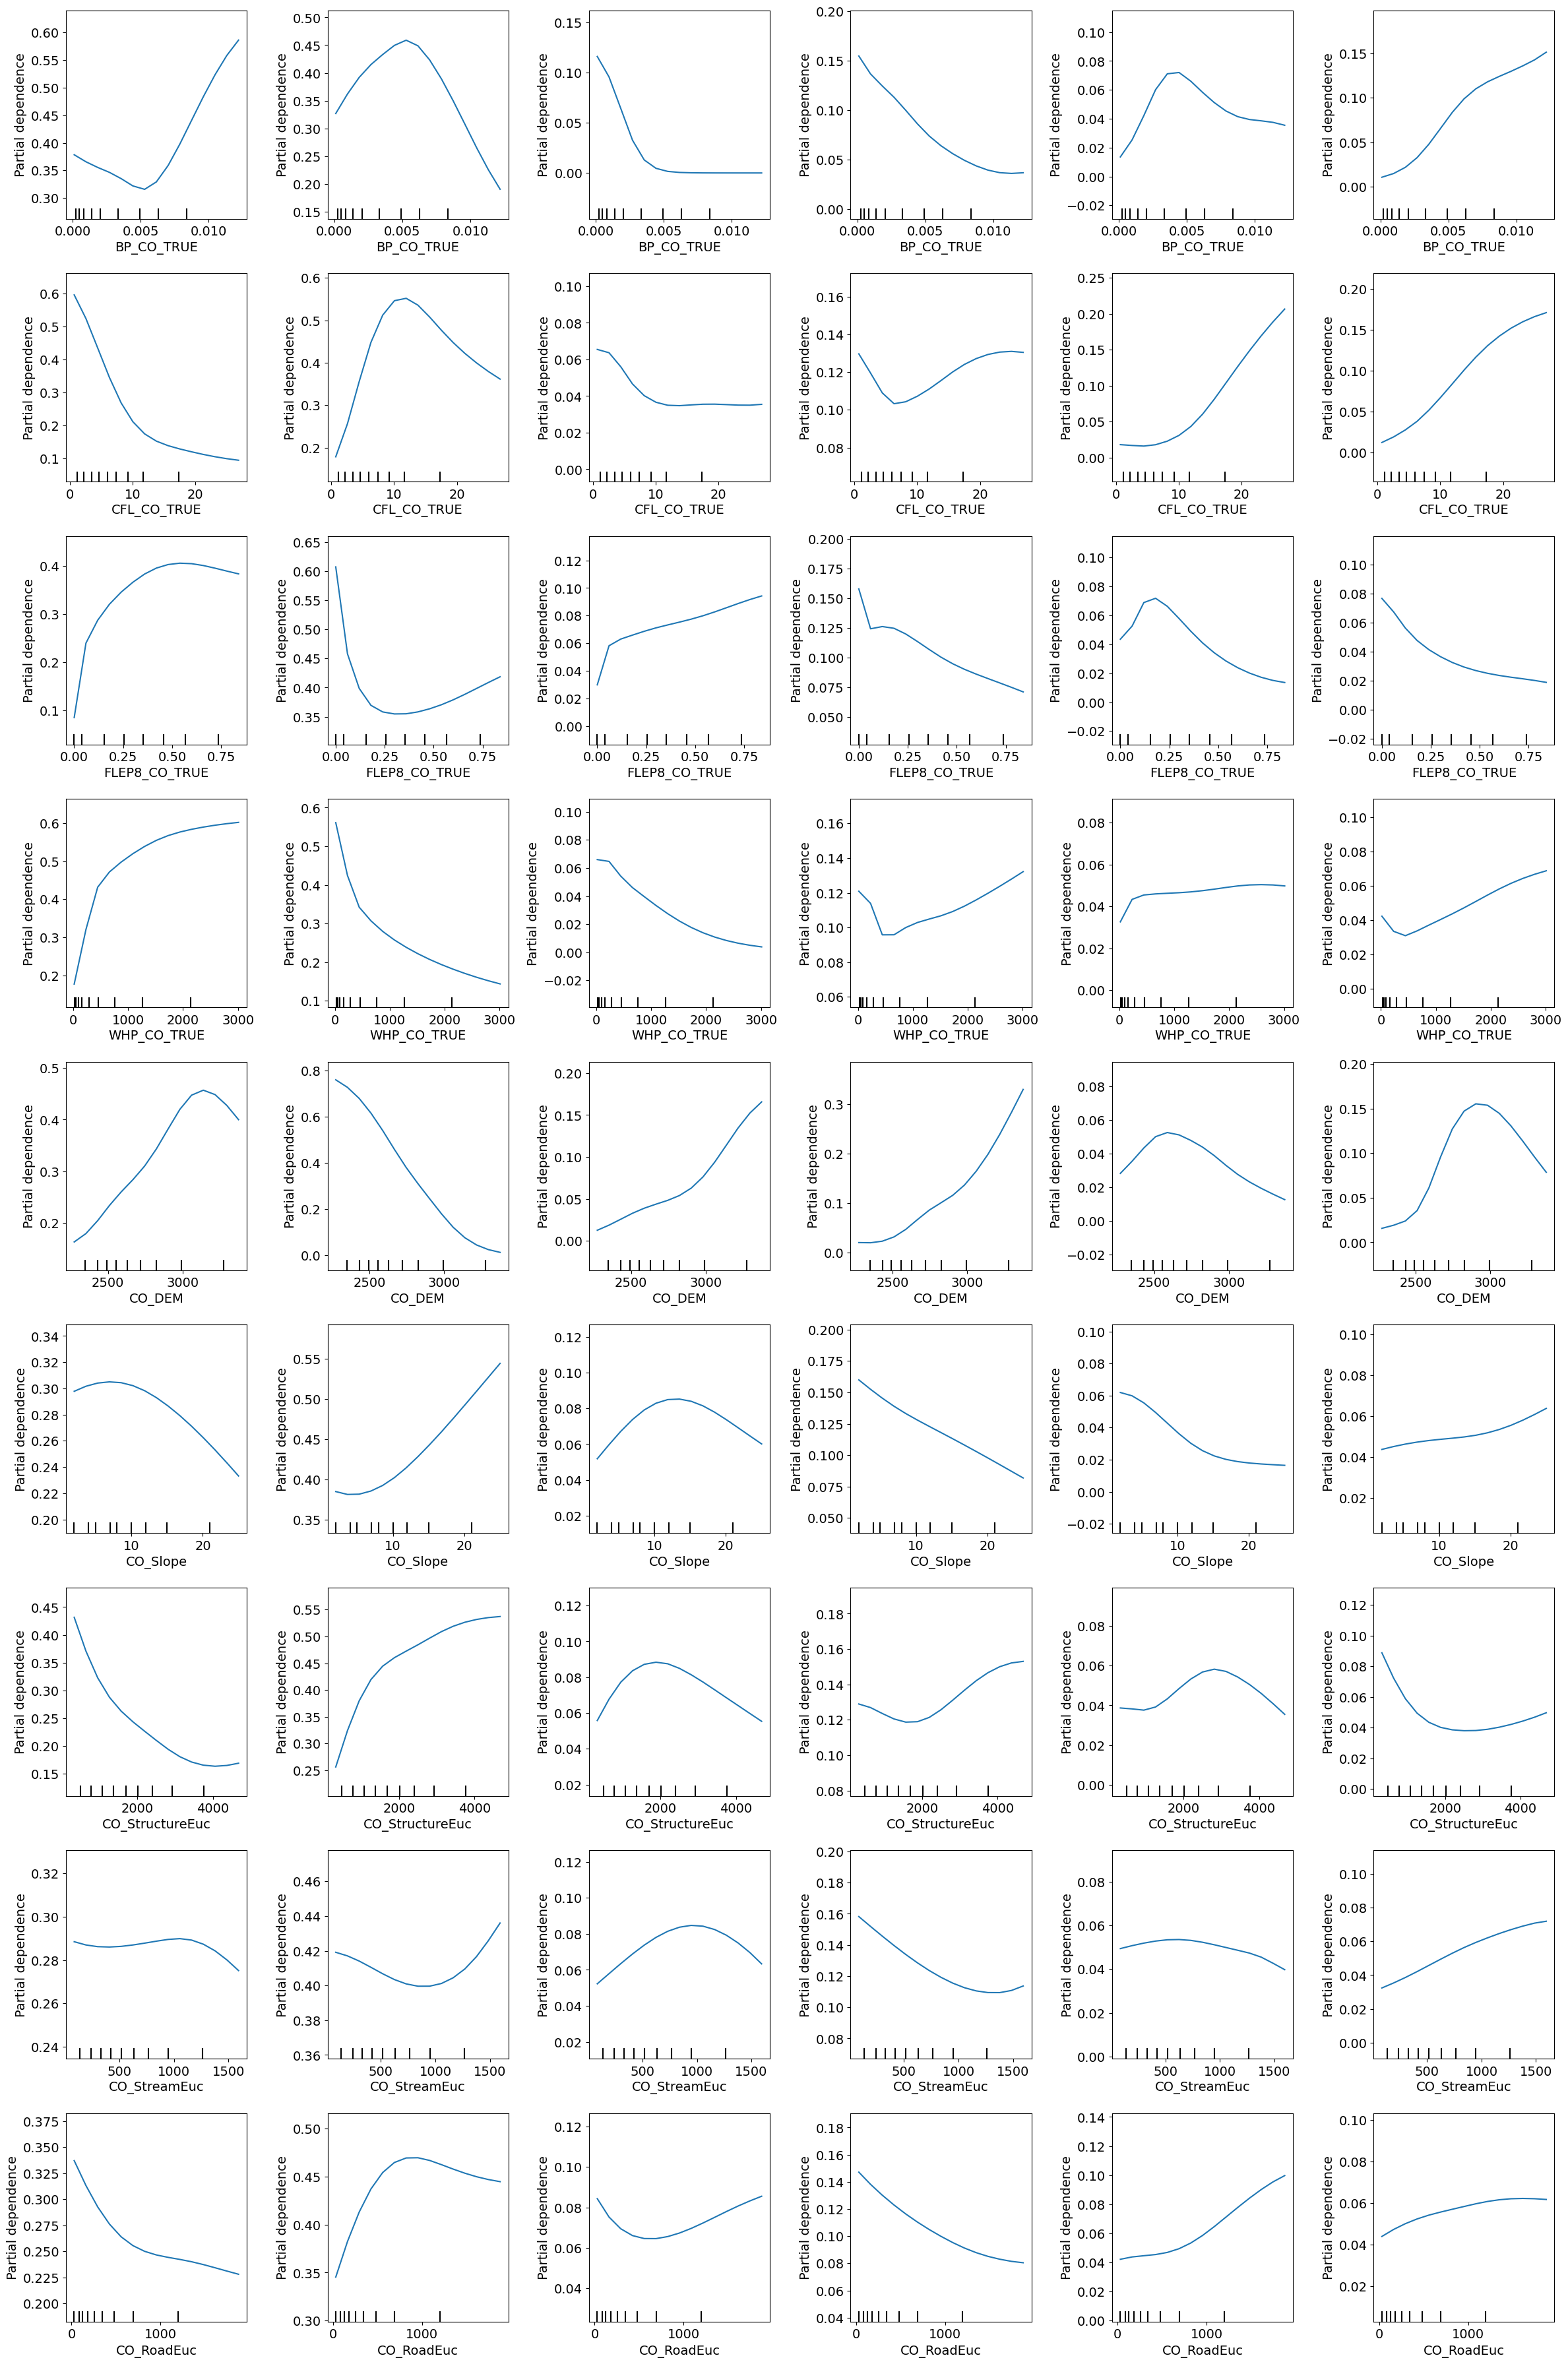

In [28]:
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.inspection import PartialDependenceDisplay
from keras.models import load_model
from joblib import load
import numpy as np
import pandas as pd
import os

# Same wrapper as before
class KerasClassifierWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, model, scaler, classes):
        self.model = model
        self.scaler = scaler
        self.classes_ = classes
        self.is_fitted_ = True

    def fit(self, X, y):
        return self

    def predict(self, X):
        X_scaled = self.scaler.transform(X)
        return np.argmax(self.model.predict(X_scaled), axis=1)

    def predict_proba(self, X):
        X_scaled = self.scaler.transform(X)
        return self.model.predict(X_scaled)

# Loading the model and scaler
# save_dir = r"C:\Users\magst\OneDrive\Pictures\Desktop\HFTCOMPELTEDATASET\MODELS"
# scaler_path = os.path.join(save_dir, 'scaler.pkl')
# scaler = load(scaler_path)
# model_path = os.path.join(save_dir, 'model.h5')
# model = load_model(model_path)

# Assuming data is loaded
X = df_filtered[['BP_CO_TRUE', 'CFL_CO_TRUE', 'FLEP8_CO_TRUE', 'WHP_CO_TRUE', 'CO_DEM', 'CO_Slope', 
                 'CO_StructureEuc', 'CO_StreamEuc', 'CO_RoadEuc']]
y = df_filtered['Treatment_Label']
one_hot_encoder = OneHotEncoder(sparse_output=False)
y_encoded = one_hot_encoder.fit_transform(y.values.reshape(-1, 1))
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.1, random_state=42)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
classes = np.array(one_hot_encoder.categories_[0])
wrapped_model = KerasClassifierWrapper(model, scaler, classes)

# Increase font size
plt.rcParams.update({'font.size': 14})  # Adjust to make font sizes larger or smaller

# Create a 6x9 grid for all features and classes
n_features = X.shape[1]
n_classes = len(classes)
fig, axes = plt.subplots(n_features, n_classes, figsize=(24, 36))

axes = axes.flatten()
features = list(X.columns)

# Define the callback function to enforce y-limits
def enforce_ylimits(event):
    for ax in event.canvas.figure.axes:
        #ax.set_ylim(0, 1)
        # Get the current y-axis limits based on the data
        y_min, y_max = ax.get_ylim()

        # Set new limits: min value minus 0.1, max value plus 0.1
        ax.set_ylim(y_min - 0.01, y_max + 0.01)

fig.canvas.mpl_connect('draw_event', enforce_ylimits)

# Plot each class's PDP for all features
plot_idx = 0
for feature_idx, feature_name in enumerate(features):
    for target_class_idx, target_class in enumerate(classes):
        print(f"Plotting PDP for Feature: {feature_name}, Class: {target_class}")

        disp = PartialDependenceDisplay.from_estimator(
            wrapped_model,
            X_test,
            [feature_idx],
            grid_resolution=15,
            target=target_class,
            ax=axes[plot_idx]
        )
        #axes[plot_idx].set_title(f'Class: {target_class} | Feature: {feature_name}', fontsize=16)  # Adjust title font size here
        axes[plot_idx].tick_params(axis='both', which='major', labelsize=12)  # Adjust tick label size here
        plot_idx += 1

for ax in axes:
    ax.set_ylim(0, 1)

plt.tight_layout()

plt.savefig('C:\\Users\\magst\\OneDrive\\Pictures\\Desktop\\HFTCOMPELTEDATASET\\SCRATCHANDFIGURES\\PDP_figure4_4.png', format='png', dpi=300)


plt.show()




In [29]:
import pandas as pd

# Function to calculate 2nd and 98th percentiles for each feature
def calculate_percentile_ranges(df, columns):
    percentile_ranges = {}
    for column in columns:
        lower = df[column].quantile(0.00)
        upper = df[column].quantile(0.98)
        percentile_ranges[column] = (lower, upper)
    return percentile_ranges

# Function to filter out-of-range values based on calculated percentile ranges
def filter_out_of_range(features_df, percentile_ranges):
    for feature, (min_val, max_val) in percentile_ranges.items():
        if feature in features_df.columns:
            # Keep only the rows where the feature is within the percentile range
            features_df = features_df[(features_df[feature] >= min_val) & (features_df[feature] <= max_val)]
    return features_df

# Example usage:
# List of columns to calculate percentiles and filter
columns_to_filter = ['WHP_CO_TRUE', 'BP_CO_TRUE', 'FLEP8_CO_TRUE', 'FLEP4_CO_TRUE', 
                     'CRPS_CO_TRUE', 'CFL_CO_TRUE', 'CO_StreamEuc', 'CO_Slope', 
                     'CO_RoadEuc', 'CO_DEM', 'CO_StructureEuc', 'us_140prs', 'us_140pms', 'us_140pls']

# Calculate the 2nd and 98th percentiles for each column
percentile_ranges = calculate_percentile_ranges(df_filtered, columns_to_filter)

# Filter the data based on the calculated percentile ranges
df_filtered_clipped = filter_out_of_range(df_filtered, percentile_ranges)

# Now df_filtered_clipped contains only values within the 2nd and 98th percentiles


In [30]:
import statistics 

# Replace original variable names with VIF-related ones and calculate summary statistics
print("WHP_CO_TRUE    - min", min(df_filtered_clipped['WHP_CO_TRUE']), "max", max(df_filtered_clipped['WHP_CO_TRUE']), 
      "Mean", statistics.mean(df_filtered_clipped['WHP_CO_TRUE']), "SD", statistics.stdev(df_filtered_clipped['WHP_CO_TRUE']))
print("BP_CO_TRUE     - min", min(df_filtered_clipped['BP_CO_TRUE']), "max", max(df_filtered_clipped['BP_CO_TRUE']), 
      "Mean", statistics.mean(df_filtered_clipped['BP_CO_TRUE']), "SD", statistics.stdev(df_filtered_clipped['BP_CO_TRUE']))
print("FLEP8_CO_TRUE  - min", min(df_filtered_clipped['FLEP8_CO_TRUE']), "max", max(df_filtered_clipped['FLEP8_CO_TRUE']), 
      "Mean", statistics.mean(df_filtered_clipped['FLEP8_CO_TRUE']), "SD", statistics.stdev(df_filtered_clipped['FLEP8_CO_TRUE']))
print("FLEP4_CO_TRUE  - min", min(df_filtered_clipped['FLEP4_CO_TRUE']), "max", max(df_filtered_clipped['FLEP4_CO_TRUE']), 
      "Mean", statistics.mean(df_filtered_clipped['FLEP4_CO_TRUE']), "SD", statistics.stdev(df_filtered_clipped['FLEP4_CO_TRUE']))
print("CRPS_CO_TRUE   - min", min(df_filtered_clipped['CRPS_CO_TRUE']), "max", max(df_filtered_clipped['CRPS_CO_TRUE']), 
      "Mean", statistics.mean(df_filtered_clipped['CRPS_CO_TRUE']), "SD", statistics.stdev(df_filtered_clipped['CRPS_CO_TRUE']))
print("CFL_CO_TRUE    - min", min(df_filtered_clipped['CFL_CO_TRUE']), "max", max(df_filtered_clipped['CFL_CO_TRUE']), 
      "Mean", statistics.mean(df_filtered_clipped['CFL_CO_TRUE']), "SD", statistics.stdev(df_filtered_clipped['CFL_CO_TRUE']))
print("CO_StreamEuc   - min", min(df_filtered_clipped['CO_StreamEuc']), "max", max(df_filtered_clipped['CO_StreamEuc']), 
      "Mean", statistics.mean(df_filtered_clipped['CO_StreamEuc']), "SD", statistics.stdev(df_filtered_clipped['CO_StreamEuc']))
print("CO_Slope       - min", min(df_filtered_clipped['CO_Slope']), "max", max(df_filtered_clipped['CO_Slope']), 
      "Mean", statistics.mean(df_filtered_clipped['CO_Slope']), "SD", statistics.stdev(df_filtered_clipped['CO_Slope']))
print("CO_RoadEuc     - min", min(df_filtered_clipped['CO_RoadEuc']), "max", max(df_filtered_clipped['CO_RoadEuc']), 
      "Mean", statistics.mean(df_filtered_clipped['CO_RoadEuc']), "SD", statistics.stdev(df_filtered_clipped['CO_RoadEuc']))
print("CO_DEM         - min", min(df_filtered_clipped['CO_DEM']), "max", max(df_filtered_clipped['CO_DEM']), 
      "Mean", statistics.mean(df_filtered_clipped['CO_DEM']), "SD", statistics.stdev(df_filtered_clipped['CO_DEM']))
print("CO_StructureEuc - min", min(df_filtered_clipped['CO_StructureEuc']), "max", max(df_filtered_clipped['CO_StructureEuc']), 
      "Mean", statistics.mean(df_filtered_clipped['CO_StructureEuc']), "SD", statistics.stdev(df_filtered_clipped['CO_StructureEuc']))
print("us_140prs      - min", min(df_filtered_clipped['us_140prs']), "max", max(df_filtered_clipped['us_140prs']), 
      "Mean", statistics.mean(df_filtered_clipped['us_140prs']), "SD", statistics.stdev(df_filtered_clipped['us_140prs']))
print("us_140pms      - min", min(df_filtered_clipped['us_140pms']), "max", max(df_filtered_clipped['us_140pms']), 
      "Mean", statistics.mean(df_filtered_clipped['us_140pms']), "SD", statistics.stdev(df_filtered_clipped['us_140pms']))
print("us_140pls      - min", min(df_filtered_clipped['us_140pls']), "max", max(df_filtered_clipped['us_140pls']), 
      "Mean", statistics.mean(df_filtered_clipped['us_140pls']), "SD", statistics.stdev(df_filtered_clipped['us_140pls']))


WHP_CO_TRUE    - min 0 max 4743 Mean 651.7111140818695 SD 851.297833515264
BP_CO_TRUE     - min 0.0 max 0.01684095 Mean 0.003387819199027951 SD 0.0033539284784335184
FLEP8_CO_TRUE  - min 0.0 max 0.9066698 Mean 0.28112056461944795 SD 0.2566273839435205
FLEP4_CO_TRUE  - min 0.0 max 0.9953255 Mean 0.5022757496932863 SD 0.33903893121227213
CRPS_CO_TRUE   - min 0.0 max 94.05943 Mean 51.929840765828146 SD 19.984821541682592
CFL_CO_TRUE    - min 0.0 max 40.485138 Mean 7.33708904340111 SD 6.395056897668432
CO_StreamEuc   - min 0.0 max 1978.4084 Mean 602.0842057890026 SD 418.2988009289604
CO_Slope       - min 0 max 30 Mean 9.50301830267182 SD 6.637367532355501
CO_RoadEuc     - min 0.0 max 3476.5068 Mean 429.1605594869784 SD 519.8668685739333
CO_DEM         - min 1894 max 3450 Mean 2691.1862592442026 SD 316.96908481096176
CO_StructureEuc - min 0.0 max 5727.172 Mean 1836.3114864412278 SD 1201.7123878229277
us_140prs      - min 1 max 16 Mean 8.120317905235487 SD 5.3408046679465535
us_140pms      -

In [31]:
# WITH FILTER - RUN TONIGHT
import geopandas as gpd
import rasterio
import numpy as np
import pandas as pd
from tqdm import tqdm
from rasterio.vrt import WarpedVRT
from rasterio.windows import from_bounds
from joblib import Parallel, delayed
from rasterio.features import rasterize
from shapely.geometry import box

# List of raster values
#raster_values = [1, 2, 3, 4, 5, 6, 7, 8, 9]
raster_values = [6, 7, 8, 9]

#raster_values = [1]

historical_ranges = {
    'WHP_CO_TRUE': (0, 4743),   # Based on min 0, max 4743, Mean 651.71, SD 851.30
    'BP_CO_TRUE': (0, 0.01684095), # Based on min 0.0, max 0.01684095, Mean 0.00339, SD 0.00335
    'FLEP8_CO_TRUE': (0, 0.9066698),   # Based on min 0.0, max 0.9066698, Mean 0.28112, SD 0.25663
    'FLEP4_CO_TRUE': (0, 0.9953255),   # Based on min 0.0, max 0.9953255, Mean 0.50228, SD 0.33904
    'CRPS_CO_TRUE': (0, 94.05943), # Based on min 0.0, max 94.05943, Mean 51.93, SD 19.98
    'CFL_CO_TRUE': (0, 40.485138), # Based on min 0.0, max 40.485138, Mean 7.34, SD 6.40
    'CO_StreamEuc': (0, 1978.4084), # Based on min 0.0, max 1978.4084, Mean 602.08, SD 418.30
    'CO_Slope': (0, 30),         # Based on min 0, max 30, Mean 9.50, SD 6.64
    'CO_RoadEuc': (0, 3476.5068),   # Based on min 0.0, max 3476.5068, Mean 429.16, SD 519.87
    'CO_DEM': (1894, 3450),      # Based on min 1894, max 3450, Mean 2691.19, SD 316.97
    'CO_StructureEuc': (0, 5727.172), # Based on min 0.0, max 5727.172, Mean 1836.31, SD 1201.71
    'us_140prs': (1, 16),        # Based on min 1, max 16, Mean 8.12, SD 5.34
    'us_140pms': (1, 13),        # Based on min 1, max 13, Mean 6.65, SD 2.54
    'us_140pls': (1, 18)         # Based on min 1, max 18, Mean 6.56, SD 5.20
}




# Function to filter out-of-range values and remove corresponding rows
def filter_out_of_range(features_df, historical_ranges):
    for feature, (min_val, max_val) in historical_ranges.items():
        if feature in features_df.columns:
            # Keep only the rows where the feature is within the range
            features_df = features_df[(features_df[feature] >= min_val) & (features_df[feature] <= max_val)]
    return features_df

# Function to process a single raster and extract values
def process_raster(raster_path, point_coords, target_crs):
    with rasterio.open(raster_path) as src:
        if src.crs != target_crs:
            vrt_options = {
                'crs': target_crs,
                'resampling': rasterio.enums.Resampling.nearest
            }
            with WarpedVRT(src, **vrt_options) as vrt:
                values = np.array(list(vrt.sample(point_coords))).flatten()
        else:
            values = np.array(list(src.sample(point_coords))).flatten()
    return values

# Main function to extract multiple raster values for points and save to CSV
def extract_multi_values_to_points(points_shapefile, raster_files, reference_raster, output_csv, n_jobs=4):
    # Load the point shapefile using GeoPandas
    points_gdf = gpd.read_file(points_shapefile)

    # Load the reference raster to get the correct CRS
    with rasterio.open(reference_raster) as ref_src:
        target_crs = ref_src.crs

    # Reproject point geometries if necessary
    if points_gdf.crs != target_crs:
        points_gdf = points_gdf.to_crs(target_crs)

    # Initialize an empty DataFrame to store the extracted values
    extracted_values = pd.DataFrame()

    # Add the point geometries to the DataFrame for reference
    extracted_values['geometry'] = points_gdf['geometry']

    # Convert point geometries to a list of coordinate tuples (x, y)
    point_coords = [(geom.x, geom.y) for geom in points_gdf.geometry]

    # Parallelize raster extraction using joblib
    extracted_values_list = Parallel(n_jobs=n_jobs)(delayed(process_raster)(raster_path, point_coords, target_crs) for raster_path in tqdm(raster_files, desc="Processing Rasters"))

    # Convert the list of arrays to DataFrame columns
    for idx, values in enumerate(extracted_values_list):
        column_name = raster_files[idx].split("\\")[-1].replace('.tif', '')
        extracted_values[column_name] = values

    # Save to CSV
    extracted_values.to_csv(output_csv, index=False)
    print(f"Extracted values saved to: {output_csv}")

    return extracted_values

# Rasterize the probability predictions for each raster value
def rasterize_probabilities(extracted_df, softmax_predictions, reference_raster, output_prefix):
    with rasterio.open(reference_raster) as src:
        transform = src.transform
        crs = src.crs
        width = src.width
        height = src.height

    nodata_value = -9999  # Set NoData value

    for i in range(softmax_predictions.shape[1]):  # Loop over each class
        class_predictions = softmax_predictions[:, i]

        # Rasterize the point predictions within the raster grid
        prob_raster = rasterize(
            ((geom, value) for geom, value in zip(extracted_df['geometry'], class_predictions)),
            out_shape=(height, width),
            transform=transform,
            fill=nodata_value,  # Set NoData value as fill
            all_touched=True,
            dtype='float32'
        )
        
        # Mask NoData cells
        prob_raster = np.ma.masked_equal(prob_raster, nodata_value)

        output_tif = f"{output_prefix}_class_{i+1}.tif"

        with rasterio.open(
            output_tif, 'w',
            driver='GTiff',
            height=height,
            width=width,
            count=1,
            dtype='float32',
            crs=crs,
            transform=transform,
            nodata=nodata_value  # Set NoData value in the output
        ) as dst:
            dst.write(prob_raster.filled(nodata_value), 1)  # Write masked array, filling NoData

        print(f"Probability raster for class {i+1} saved to {output_tif}")

# Loop through each raster value and extract data
for i in range(len(raster_values)):
    points_shapefile = f"C:\\Users\\magst\\OneDrive\\Pictures\\Desktop\\HFTCOMPELTEDATASET\\Selected_NF_{raster_values[i]}_points.shp"
    reference_raster = r"C:\Users\magst\OneDrive\Pictures\Desktop\HFTCOMPELTEDATASET\NatForest_CO_Name.tif"
    
    # List of raster files for extraction
    raster_files = [
        r"C:\Users\magst\OneDrive\Pictures\Desktop\HFTCOMPELTEDATASET\CHAPTER1_DataRerun\WRC2024\CO2\BP_CO2.tif",
        r"C:\Users\magst\OneDrive\Pictures\Desktop\HFTCOMPELTEDATASET\CHAPTER1_DataRerun\WRC2024\CO2\CFL_CO2.tif",
        r"C:\Users\magst\OneDrive\Pictures\Desktop\HFTCOMPELTEDATASET\CHAPTER1_DataRerun\WRC2024\CO2\FLEP8_CO2.tif",
        r"C:\Users\magst\OneDrive\Pictures\Desktop\HFTCOMPELTEDATASET\CHAPTER1_DataRerun\WRC2024\CO2\WHP_CO2.tif",
        r"C:\Users\magst\OneDrive\Pictures\Desktop\HFTCOMPELTEDATASET\CO_DEM.tif",
        r"C:\Users\magst\OneDrive\Pictures\Desktop\HFTCOMPELTEDATASET\CO_Slope.tif",
        r"C:\Users\magst\OneDrive\Pictures\Desktop\HFTCOMPELTEDATASET\CO_StructureEuc.tif",
        r"C:\Users\magst\OneDrive\Pictures\Desktop\HFTCOMPELTEDATASET\CO_StreamEuc.tif",
        r"C:\Users\magst\OneDrive\Pictures\Desktop\HFTCOMPELTEDATASET\CO_RoadEuc.tif"
    ]
    
    # Output CSV path for each iteration
    output_csv = f"C:\\Users\\magst\\OneDrive\\Pictures\\Desktop\\HFTCOMPELTEDATASET\\extracted_model_values_98percent_{raster_values[i]}.csv"
    
    # Extract raster values for current points shapefile
    extracted_df = extract_multi_values_to_points(points_shapefile, raster_files, reference_raster, output_csv, n_jobs=4)
    
    # Rename columns to match those used during training
    extracted_df = extracted_df.rename(columns={
        'BP_CO2': 'BP_CO_TRUE',
        'CFL_CO2': 'CFL_CO_TRUE',
        'FLEP8_CO2': 'FLEP8_CO_TRUE',
        'WHP_CO2': 'WHP_CO_TRUE'
    })
    
    # Step 1: Filter out out-of-range values by removing those rows
    extracted_df = filter_out_of_range(extracted_df, historical_ranges)
    
    # Step 2: Prepare features for prediction (if there are still rows left after filtering)
    if not extracted_df.empty:
        features = extracted_df.drop(columns=['geometry'])
        scaled_features = scaler.transform(features)  # Assuming 'scaler' is pre-fitted
    
        # Step 3: Predict using the model
        softmax_predictions = model.predict(scaled_features)  # Assuming 'model' is pre-trained
    
        # Step 4: Rasterize and save the probability rasters
        output_prefix = f"C:\\Users\\magst\\OneDrive\\Pictures\\Desktop\\HFT_FinalRun\\modeloutput\\predicted_prob_98p_{raster_values[i]}"
        rasterize_probabilities(extracted_df, softmax_predictions, reference_raster, output_prefix)

print("Processing and rasterization completed for all raster values.")


Processing Rasters: 100%|███████████████████████████████████████████████████████████████| 9/9 [15:51<00:00, 105.76s/it]


Extracted values saved to: C:\Users\magst\OneDrive\Pictures\Desktop\HFTCOMPELTEDATASET\extracted_model_values_98percent_6.csv
205872/205872 ━━━━━━━━━━━━━━━━━━━━ 353s 2ms/step
Probability raster for class 1 saved to C:\Users\magst\OneDrive\Pictures\Desktop\HFT_FinalRun\modeloutput\predicted_prob_98p_6_class_1.tif
Probability raster for class 2 saved to C:\Users\magst\OneDrive\Pictures\Desktop\HFT_FinalRun\modeloutput\predicted_prob_98p_6_class_2.tif
Probability raster for class 3 saved to C:\Users\magst\OneDrive\Pictures\Desktop\HFT_FinalRun\modeloutput\predicted_prob_98p_6_class_3.tif
Probability raster for class 4 saved to C:\Users\magst\OneDrive\Pictures\Desktop\HFT_FinalRun\modeloutput\predicted_prob_98p_6_class_4.tif
Probability raster for class 5 saved to C:\Users\magst\OneDrive\Pictures\Desktop\HFT_FinalRun\modeloutput\predicted_prob_98p_6_class_5.tif
Probability raster for class 6 saved to C:\Users\magst\OneDrive\Pictures\Desktop\HFT_FinalRun\modeloutput\predicted_prob_98p_6_cla

Processing Rasters: 100%|████████████████████████████████████████████████████████████████| 9/9 [08:41<00:00, 57.93s/it]


Extracted values saved to: C:\Users\magst\OneDrive\Pictures\Desktop\HFTCOMPELTEDATASET\extracted_model_values_98percent_7.csv
132909/132909 ━━━━━━━━━━━━━━━━━━━━ 229s 2ms/step
Probability raster for class 1 saved to C:\Users\magst\OneDrive\Pictures\Desktop\HFT_FinalRun\modeloutput\predicted_prob_98p_7_class_1.tif
Probability raster for class 2 saved to C:\Users\magst\OneDrive\Pictures\Desktop\HFT_FinalRun\modeloutput\predicted_prob_98p_7_class_2.tif
Probability raster for class 3 saved to C:\Users\magst\OneDrive\Pictures\Desktop\HFT_FinalRun\modeloutput\predicted_prob_98p_7_class_3.tif
Probability raster for class 4 saved to C:\Users\magst\OneDrive\Pictures\Desktop\HFT_FinalRun\modeloutput\predicted_prob_98p_7_class_4.tif
Probability raster for class 5 saved to C:\Users\magst\OneDrive\Pictures\Desktop\HFT_FinalRun\modeloutput\predicted_prob_98p_7_class_5.tif
Probability raster for class 6 saved to C:\Users\magst\OneDrive\Pictures\Desktop\HFT_FinalRun\modeloutput\predicted_prob_98p_7_cla

Processing Rasters: 100%|███████████████████████████████████████████████████████████████| 9/9 [23:36<00:00, 157.44s/it]


Extracted values saved to: C:\Users\magst\OneDrive\Pictures\Desktop\HFTCOMPELTEDATASET\extracted_model_values_98percent_8.csv
188739/188739 ━━━━━━━━━━━━━━━━━━━━ 320s 2ms/step
Probability raster for class 1 saved to C:\Users\magst\OneDrive\Pictures\Desktop\HFT_FinalRun\modeloutput\predicted_prob_98p_8_class_1.tif
Probability raster for class 2 saved to C:\Users\magst\OneDrive\Pictures\Desktop\HFT_FinalRun\modeloutput\predicted_prob_98p_8_class_2.tif
Probability raster for class 3 saved to C:\Users\magst\OneDrive\Pictures\Desktop\HFT_FinalRun\modeloutput\predicted_prob_98p_8_class_3.tif
Probability raster for class 4 saved to C:\Users\magst\OneDrive\Pictures\Desktop\HFT_FinalRun\modeloutput\predicted_prob_98p_8_class_4.tif
Probability raster for class 5 saved to C:\Users\magst\OneDrive\Pictures\Desktop\HFT_FinalRun\modeloutput\predicted_prob_98p_8_class_5.tif
Probability raster for class 6 saved to C:\Users\magst\OneDrive\Pictures\Desktop\HFT_FinalRun\modeloutput\predicted_prob_98p_8_cla

DataSourceError: C:\Users\magst\OneDrive\Pictures\Desktop\HFTCOMPELTEDATASET\Selected_NF_9_points.shp: No such file or directory